# GenHack 4 - ChefAI - Data Exploration



- **Group**: ChefAI
- **Period**: 1 - Warm-up

## Introduction

In this notebook we will explore the datasets provided for the competition. The goal is to understand the structure, content, and potential challenges of the data.

We will consider these three datasets:

- The [GADM](https://gadm.org/) dataset for geographical administrative boundaries.
- The [ERA5-Land](https://cds.climate.copernicus.eu/datasets/derived-era5-land-daily-statistics) dataset for the evolution of land variables over several decades at an enhanced resolution compared to ERA5.
- The [ECA](https://www.ecad.eu/) blended climate dataset for historical climate data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

In [2]:
data_dir = "../data"

## GADM Dataset Exploration

GADM (Global Administrative Database) is a high-resolution database of global administrative areas. It provides detailed maps and data for countries, regions, and localities.

The current version is **4.1**. It delimits **400,276** administrative areas.

**License**: The data are freely available for academic use and other non-commercial use. Redistribution, or commercial use is not allowed without prior permission. See the license for more details. For more information, visit the [GADM license page](https://gadm.org/license.html).

### Loading the Data

The organizers have provided both the entire global dataset and a subset for Europe. We will start by loading the European subset.

The data is in the form of a [GeoPackage](https://www.geopackage.org/) file, a standard format for storing geospatial data.

We will use the `geopandas` library to read and explore the data.

In [3]:
import os.path
import geopandas as gpd

gadm_path = os.path.join(data_dir, "gadm_410_europe.gpkg")
gadm_gdf = gpd.read_file(gadm_path)

print(f"GADM shape: {gadm_gdf.shape}")
gadm_gdf.head()

GADM shape: (106252, 21)


UID GID_0 NAME_0    GID_1       NAME_1   ENGTYPE_1      GID_2    NAME_2  \
0  333   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.1_2    Brändö   
1  334   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.2_2     Föglö   
2  335   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.3_2     Kökar   
3  336   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.4_2  Kumlinge   
4  337   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.1_2  Sottunga   

      ENGTYPE_2 GID_3  ... ENGTYPE_3 GID_4 NAME_4 ENGTYPE_4 GID_5 NAME_5  \
0  Municipality        ...                                                 
1  Municipality        ...                                                 
2  Municipality        ...                                                 
3  Municipality        ...                                                 
4  Municipality        ...                                                 

  ENGTYPE_5 COUNTRY CONTINENT  \
0             Åland    Europe   
1             Åland    Europe   
2             Åland    Europe   
3             Åland    Europe   
4             Åland    Europe   

                                            geometry  
0  MULTIPOLYGON (((20.98333 60.64167, 20.98125 60...  
1  MULTIPOLYGON (((20.60028 59.81311, 20.60027 59...  
2  MULTIPOLYGON (((20.83333 60.03333, 20.83301 60...  
3  MULTIPOLYGON (((20.76042 60.46667, 20.75833 60...  
4  MULTIPOLYGON (((20.56875 60.18333, 20.56667 60...  

[5 rows x 21 columns]

### Data Exploration

#### Administrative Levels

The GADM dataset follows a hierarchical structure of administrative divisions, using numerical suffixes to denote different levels:

- `GID_0`: Country level
- `GID_1`: First-level administrative division (e.g., states, provinces)
- `GID_2`: Second-level administrative division (e.g., counties, districts)
- ...

Different countries may have varying numbers of administrative levels, and the types of divisions can differ significantly.

We can inspect the dataset to understand the distribution of these administrative levels and their types.

The `ENGTYPE_X` columns provide English descriptions of the administrative division types at each level.

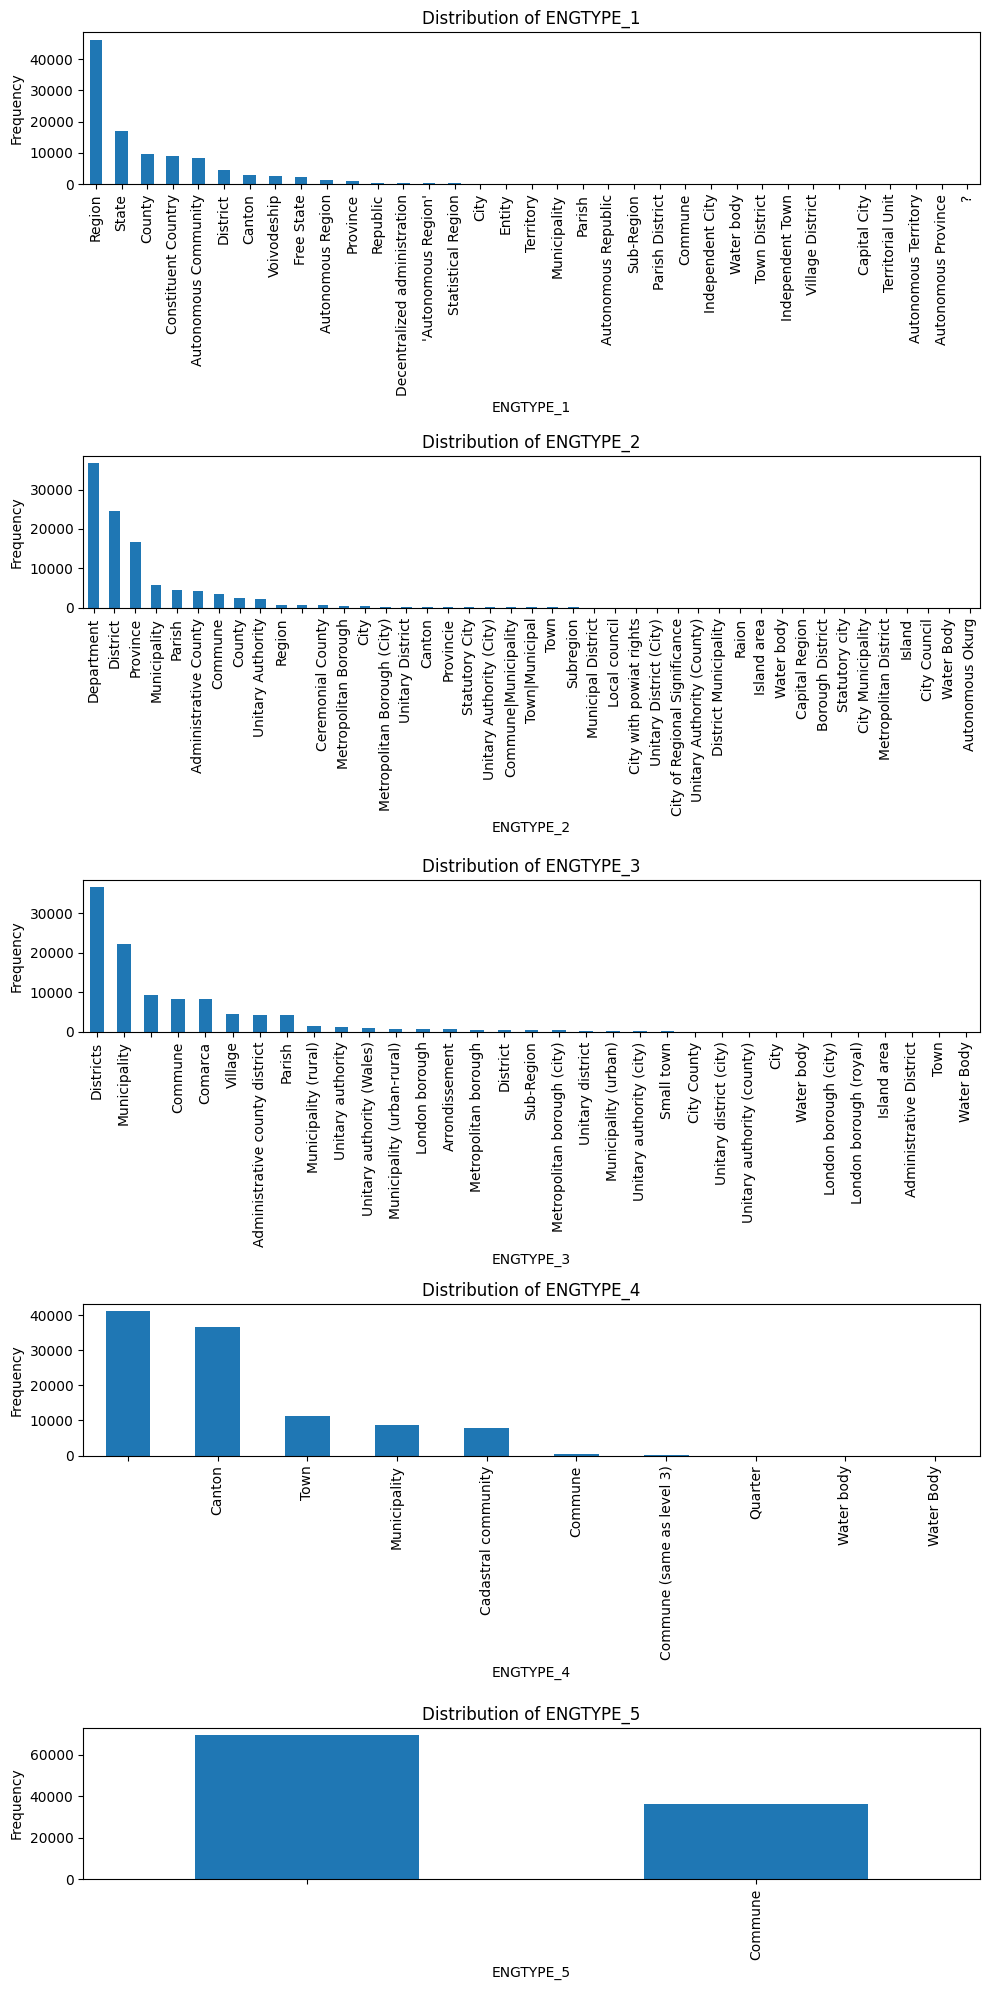

In [4]:
fig, axes = plt.subplots(5, 1, figsize=(10, 4 * 5))

for i, col in enumerate([f"ENGTYPE_{i}" for i in range(1, 6)]):
    gadm_gdf[col].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Surely enough, we can see a variety of division types such as "Country", "Region", "Province", "District", "Municipality", etc.

We can also visualize the geographical boundaries of these administrative areas using the geometrical data provided in the dataset.

To do that, we can reduce the dimensionality of the dataset by dissolving it based on a specific administrative type, for example, `ENGTYPE_1`. Dissolving merges geometries of the same type into single entities, allowing to only consider the first level divisions.

In [5]:
gadm_level1_gdf = gadm_gdf.dissolve(by="GID_1", method="coverage")

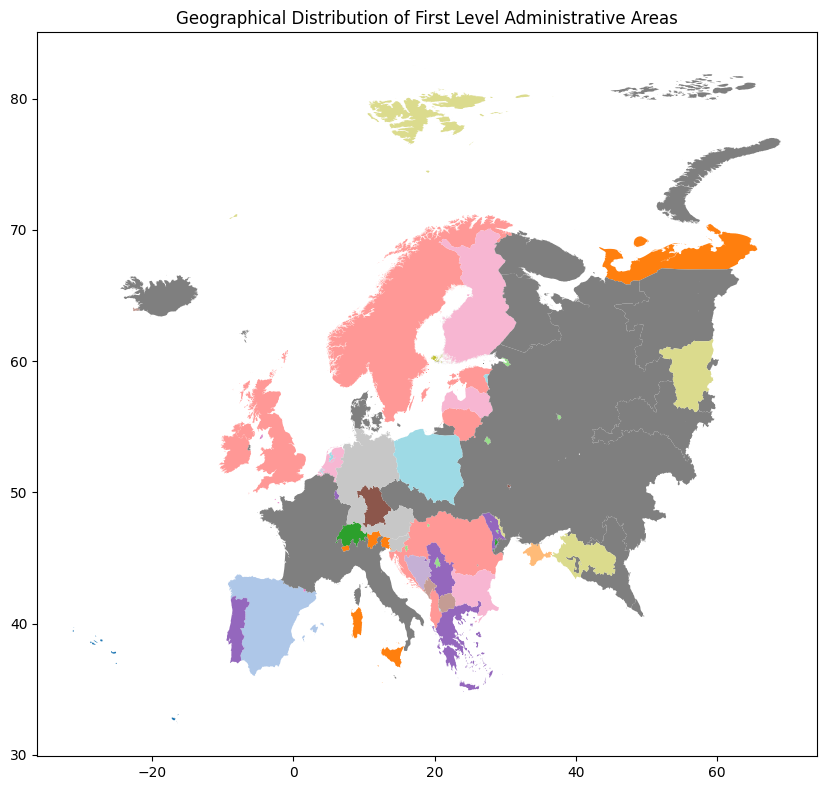

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
gadm_gdf.dissolve(by="ENGTYPE_1", method="coverage").plot(
    ax=plt.gca(), cmap="tab20", legend=True
)
plt.title("Geographical Distribution of First Level Administrative Areas")
plt.tight_layout(rect=(0, 0, 0.85, 1))
plt.show()

We can see that each nation has a very limited set of unique denominations for its first level divisions.

Let's visualize first level divisions in Italy as an example.

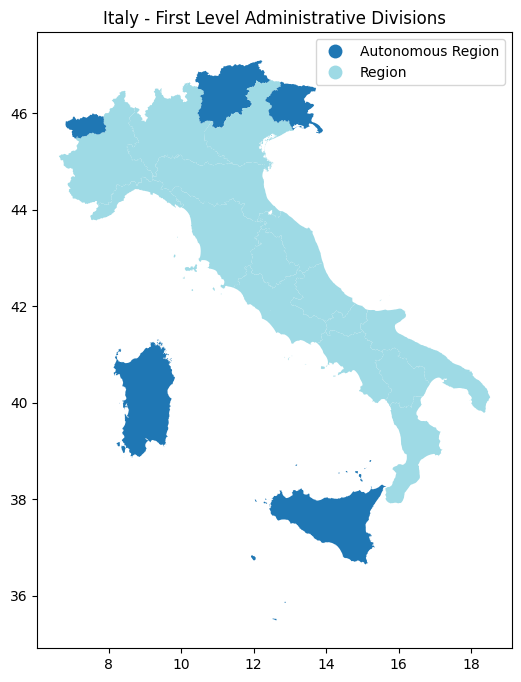

In [7]:
import matplotlib.pyplot as plt

italy_level1_gdf = gadm_level1_gdf[gadm_level1_gdf["GID_0"] == "ITA"]
plt.figure(figsize=(10, 8))
italy_level1_gdf.plot(ax=plt.gca(), column="ENGTYPE_1", legend=True, cmap="tab20")
plt.title("Italy - First Level Administrative Divisions")
plt.show()

Let's analyze each `ENGTYPE_X` column to see the unique types of administrative divisions at each level for Italy.

In [8]:
for i in range(1, 6):
    print(gadm_gdf[gadm_gdf["GID_0"] == "ITA"][f"ENGTYPE_{i}"].value_counts(), "\n")

ENGTYPE_1
Region               6701
Autonomous Region    1399
Name: count, dtype: int64 

ENGTYPE_2
Province    8100
Name: count, dtype: int64 

ENGTYPE_3
Commune    8100
Name: count, dtype: int64 

ENGTYPE_4
    8100
Name: count, dtype: int64 

ENGTYPE_5
    8100
Name: count, dtype: int64 



We have only three levels of administrative divisions in Italy:
- Level 1: Region
- Level 2: Province
- Level 3: Municipality

## ERA5 Dataset Exploration

ERA5 is the fifth generation ECMWF reanalysis providing global climate data from 1950 to present at ~0.1° resolution.

ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5.

ERA5-Land has been produced by replaying the land component of the ECMWF ERA5 climate reanalysis. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics.

### Data Description

The ERA5-Land dataset is provided in NetCDF format, which is commonly used for storing multi-dimensional scientific data.

| Dataset               | ERA5-Land                                                                                                                                                          |
| --------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Data type             | Gridded                                                                                                                                                            |
| Projection            | Regular latitude-longitude grid                                                                                                                                    |
| Horizontal coverage   | Global                                                                                                                                                             |
| Horizontal resolution | 0.1° x 0.1°                                                                                                                                                        |
| Vertical coverage     | From 2 m above the surface level, to a soil depth of 289 cm.                                                                                                       |
| Vertical resolution   | 4 levels of the ECMWF surface model: Layer 1: 0 -7cm, Layer 2: 7 -28cm, Layer 3: 28-100cm, Layer 4: 100-289cm Some parameters are defined at 2 m over the surface. |
| Temporal coverage     | January 1950 to present                                                                                                                                            |
| Temporal resolution   | Daily                                                                                                                                                              |

### Main Variables

| Variable Name           | Units | Description                                                                                                                                                                                                |
| ----------------------- | ----- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 10m u-component of wind | m/s   | Eastward component of wind at 10 meters above the surface                                                                                                                                                  |
| 10m v-component of wind | m/s   | Northward component of wind at 10 meters above the surface                                                                                                                                                 |
| 2m dewpoint temperature | K     | Dewpoint temperature at 2 meters above the surface                                                                                                                                                         |
| 2m temperature          | K     | Temperature at 2 meters above the surface                                                                                                                                                                  |
| Forecast albedo         | 0-1   | Is a measure of the reflectivity of the Earth's surface. It is the fraction of solar (shortwave) radiation reflected by Earth's surface, across the solar spectrum, for both direct and diffuse radiation. |


### Data Loading

#### Coordinate Reference System

As specified in the previous table, the ERA5-Land dataset uses a regular latitude-longitude grid.
This means that the data is organized in a grid format where each grid cell corresponds to a specific latitude and longitude coordinate.

The coordinate reference system (CRS) used is EPSG:4326, also known as WGS 84, which is a standard for global latitude and longitude coordinates.


In [9]:
era5_crs = "EPSG:4326"

In [10]:
import os.path

era5_data_folder = os.path.join(data_dir, "derived-era5-land-daily-statistics")
era5_data_folder

'../data/derived-era5-land-daily-statistics'

#### Single Variable Loading

We could load the entire ERA5-Land dataset with all the variables, but given its size, we will select a variable of interest for our initial exploration.

In [11]:
# Variable of interest - try changing this to explore different variables!
# Options:
# - "2m_temperature",
# - "total_precipitation",
# - "10m_u_component_of_wind",
# - "10m_v_component_of_wind"
voi = "2m_temperature"

In [12]:
# Mapping from variable names to their statistical aggregations
variable2statistic = {
    "2m_temperature": "daily_maximum",  # Maximum temperature each day
    "total_precipitation": "daily_mean",  # Mean precipitation each day
    "10m_u_component_of_wind": "daily_mean",  # Mean eastward wind component
    "10m_v_component_of_wind": "daily_mean",  # Mean northward wind component
}

# Mapping to the actual variable names in the NetCDF files
variable2datavar = {
    "2m_temperature": "t2m",  # Temperature at 2 meters above surface
    "total_precipitation": "tp",  # Total precipitation
    "10m_u_component_of_wind": "u10",  # U (eastward) wind component at 10m
    "10m_v_component_of_wind": "v10",  # V (northward) wind component at 10m
}

statistic = variable2statistic[voi]
datavar = variable2datavar[voi]

print(f"{'Variable of Interest':>22} : {voi}")
print(f"{'Statistic':>22} : {statistic}")
print(f"{'Data Variable':>22} : {datavar}")

  Variable of Interest : 2m_temperature
             Statistic : daily_maximum
         Data Variable : t2m


We can now search in the ERA5-Land data folder for files matching our variable of interest and its statistic.

In [13]:
import glob
import os.path

era5_glob_pattern = os.path.join(era5_data_folder, f"*_{voi}_{statistic}.nc")
era5_filepaths = glob.glob(era5_glob_pattern)
era5_filepaths.sort()

print(f"Found {len(era5_filepaths)} files:")
for fp in era5_filepaths:
    print(" -", fp)

Found 6 files:
 - ../data/derived-era5-land-daily-statistics/2020_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2021_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2022_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2023_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2024_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2025_2m_temperature_daily_maximum.nc


`xr.open_mfdataset` from the `xarray` library allows us to open multiple NetCDF files as a single xarray dataset, which is very useful for handling large datasets split across multiple files.

In [14]:
era5_ds = xr.open_mfdataset(era5_filepaths, combine="by_coords")
era5_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2098, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

We see that the dataset contains dimensions for time, latitude, and longitude, along with the variable of interest (e.g., t2m) and associated coordinates. 

Let's select the variable data array.

In [15]:
era5_var = era5_ds[datavar]
era5_var

<xarray.DataArray 't2m' (valid_time: 2098, latitude: 350, longitude: 660)> Size: 2GB
dask.array<concatenate, shape=(2098, 350, 660), dtype=float32, chunksize=(23, 22, 42), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

The array is a 3D DataArray with dimensions for time, latitude, and longitude. Each entry in the array represents the value of the variable of interest (e.g., temperature) at a specific time and geographic location. 

The coordinates provide the actual latitude and longitude values corresponding to the indices in the array.


`xarray` automatically uses lazy loading, meaning that data is not loaded into memory until it is explicitly accessed. This is what the "Chunk" attribute indicates.

### Data Exploration

We can start by printing some basic information about the dataset structure, including dimensions, intervals and geographical coverage.

In [16]:
print(f"Data Shape: {era5_var.shape}")
print(f"   - Time steps: {len(era5_var.valid_time)}")
print(f"   - Latitude points: {len(era5_var.latitude)}")
print(f"   - Longitude points: {len(era5_var.longitude)}")
print("\nTime Coverage:")
print(f"   - Start: {era5_var.valid_time.min().values}")
print(f"   - End: {era5_var.valid_time.max().values}")
print("\nGeographic Coverage:")
print(f"   - Latitude: {era5_var.latitude.min().values:.2f}° to {era5_var.latitude.max().values:.2f}°")
print(f"   - Longitude: {era5_var.longitude.min().values:.2f}° to {era5_var.longitude.max().values:.2f}°")

Data Shape: (2098, 350, 660)
   - Time steps: 2098
   - Latitude points: 350
   - Longitude points: 660

Time Coverage:
   - Start: 2020-01-01T00:00:00.000000000
   - End: 2025-09-28T00:00:00.000000000

Geographic Coverage:
   - Latitude: 35.00° to 69.90°
   - Longitude: -25.00° to 40.90°


#### Sample Visualization: Entire Domain

<Figure size 640x480 with 0 Axes>

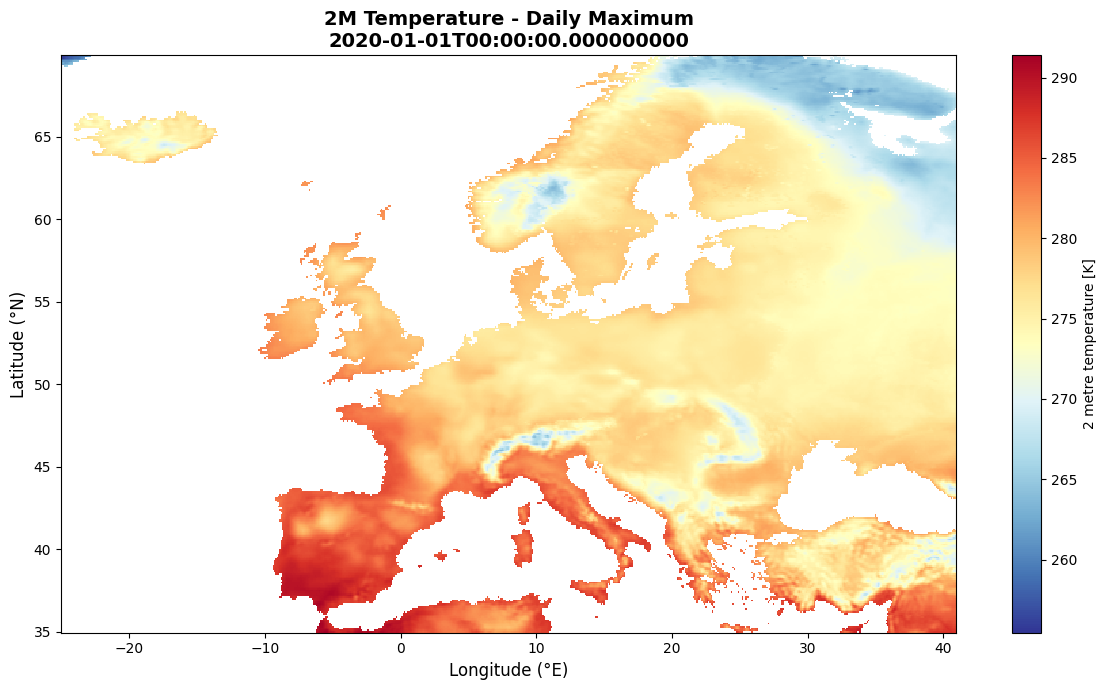

In [17]:
# Select a specific day to visualize
era5_var_day = era5_var.isel(valid_time=0)

plt.figure()
era5_var_day.plot(figsize=(12, 7), cmap="RdYlBu_r")
plt.title(
    f"{voi.replace('_', ' ').title()} - {statistic.replace('_', ' ').title()}\n{era5_var_day.valid_time.values}",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.tight_layout()
plt.show()

#### Spatial Resolution Analysis

ERA5-Land uses 0.1° × 0.1° grid.

Because the dataset uses a regular latitude-longitude grid, and because the Earth is a geoid, the actual physical size of each grid cell varies with latitude.

In particular, the east-west extent of a grid cell decreases as one moves from the equator towards the poles, while the north-south extent remains relatively constant.

In [18]:
# Constants: distance per degree at the equator
lat_deg_len_eq = 110.574  # km per degree latitude
lon_deg_len_eq = 111.320  # km per degree longitude at equator

# Calculate grid spacing
latitude_step = np.abs(era5_var.latitude[1] - era5_var.latitude[0]).item()
longitude_step = np.abs(era5_var.longitude[1] - era5_var.longitude[0]).item()

print("Grid Resolution:")
print(f"   Latitude spacing: {latitude_step:.4f}°")
print(f"   Longitude spacing: {longitude_step:.4f}°")

# How resolution changes with latitude
print("\nPhysical distance per grid cell at different latitudes:")
print("=" * 70)

km_per_deg = pd.DataFrame(
    {
        "Latitude (°)": [0, 15, 30, 45, 60, 75, 90],
        "Lat (km/deg)": [110.574, 110.649, 110.852, 111.133, 111.412, 111.618, 111.694],
        "Lon (km/deg)": [111.320, 107.551, 96.486, 78.847, 55.800, 28.902, 0.000],
    }
)

for index, row in km_per_deg.iterrows():
    lat_km = row["Lat (km/deg)"] * latitude_step
    lon_km = row["Lon (km/deg)"] * longitude_step
    cell_area = lat_km * lon_km
    print(
        f"At {row['Latitude (°)']:>3.0f}° latitude: "
        f"{lat_km:>5.2f} km (N-S) × {lon_km:>5.2f} km (E-W) = {cell_area:>7.1f} km²"
    )

Grid Resolution:
   Latitude spacing: 0.1000°
   Longitude spacing: 0.1000°

Physical distance per grid cell at different latitudes:
At   0° latitude: 11.06 km (N-S) × 11.13 km (E-W) =   123.1 km²
At  15° latitude: 11.06 km (N-S) × 10.76 km (E-W) =   119.0 km²
At  30° latitude: 11.09 km (N-S) ×  9.65 km (E-W) =   107.0 km²
At  45° latitude: 11.11 km (N-S) ×  7.88 km (E-W) =    87.6 km²
At  60° latitude: 11.14 km (N-S) ×  5.58 km (E-W) =    62.2 km²
At  75° latitude: 11.16 km (N-S) ×  2.89 km (E-W) =    32.3 km²
At  90° latitude: 11.17 km (N-S) ×  0.00 km (E-W) =     0.0 km²


#### Spatial Regional Analysis: Italy

From now on, we will focus our analysis on Italy. Let's extract data for Italy using a manually defined bounding box.

In [19]:
italy_bbox = {"min_lon": 6.627, "max_lon": 18.784, "min_lat": 36.619, "max_lat": 47.092}

era5_var_italy = era5_var.sel(
    longitude=slice(italy_bbox["min_lon"], italy_bbox["max_lon"]),
    latitude=slice(italy_bbox["max_lat"], italy_bbox["min_lat"]),
)

era5_var_italy

<xarray.DataArray 't2m' (valid_time: 2098, latitude: 104, longitude: 121)> Size: 106MB
dask.array<getitem, shape=(2098, 104, 121), dtype=float32, chunksize=(23, 22, 42), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 832B 47.0 46.9 46.8 46.7 ... 36.9 36.8 36.7
  * longitude   (longitude) float64 968B 6.7 6.8 6.9 7.0 ... 18.4 18.5 18.6 18.7
    number      int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

We can check the dimensions of the extracted dataset to confirm that it covers the expected geographical area.

To do that, let's plot the data for Italy for the first day in the dataset.

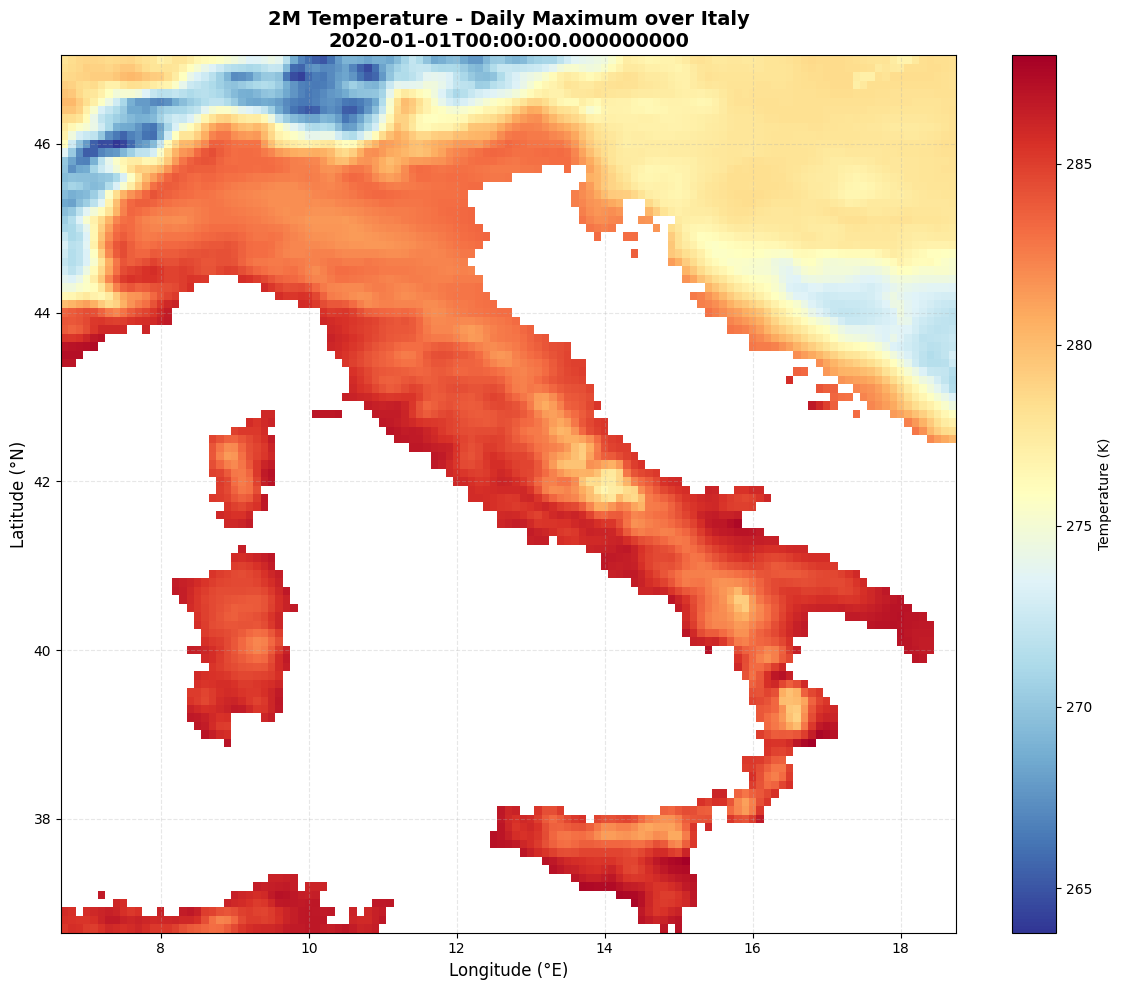

In [20]:
era5_var_italy_day0 = era5_var_italy.isel(valid_time=0)

# Visualize temperature over Italy for the first day
fig, ax = plt.subplots(figsize=(12, 10))
era5_var_italy_day0.plot(
    ax=ax, cmap="RdYlBu_r", cbar_kwargs={"label": "Temperature (K)"}
)
plt.title(
    (
        f"{voi.replace('_', ' ').title()} - {statistic.replace('_', ' ').title()} over Italy"
        f"\n{str(era5_var_italy_day0.valid_time.values)}"
    ),
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

#### Point-Based Time Series: Italy

Other than spatial analysis, we can also perform point-based time series analysis for specific locations.

Let's extract time series for major Italian cities:

In [21]:
cities = {
    "Rome": {"lat": 41.9028, "lon": 12.4964},
    "Milan": {"lat": 45.4642, "lon": 9.1900},
    "Naples": {"lat": 40.8518, "lon": 14.2681},
    "Palermo": {"lat": 38.1157, "lon": 13.3615},
}

# Extract time series for Rome using nearest neighbor selection
rome_ts = era5_var_italy.sel(
    latitude=cities["Rome"]["lat"], longitude=cities["Rome"]["lon"], method="nearest"
)

print(f"Data points: {len(rome_ts)}")

Data points: 2098


We can plot the time series for Rome as follows:

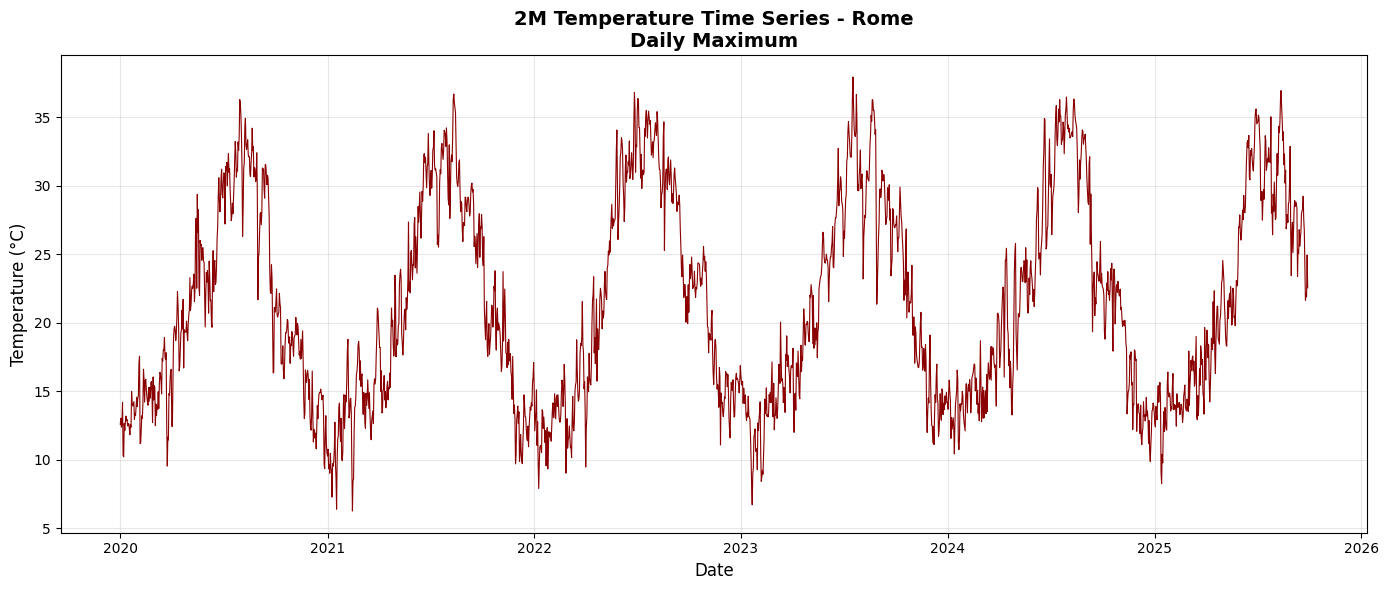

In [22]:
# Plot time series for Rome
fig, ax = plt.subplots(figsize=(14, 6))

# Convert Kelvin to Celsius if temperature
if voi == "2m_temperature":
    (rome_ts - 273.15).plot(ax=ax, linewidth=0.8, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    rome_ts.plot(ax=ax, linewidth=0.8)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"{voi.replace('_', ' ').title()} Time Series - Rome\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Multi-City Comparison

We could also compare the temperature trends across multiple cities in Italy.

Let's plot the time series for some of Italy's major cities together for comparison:

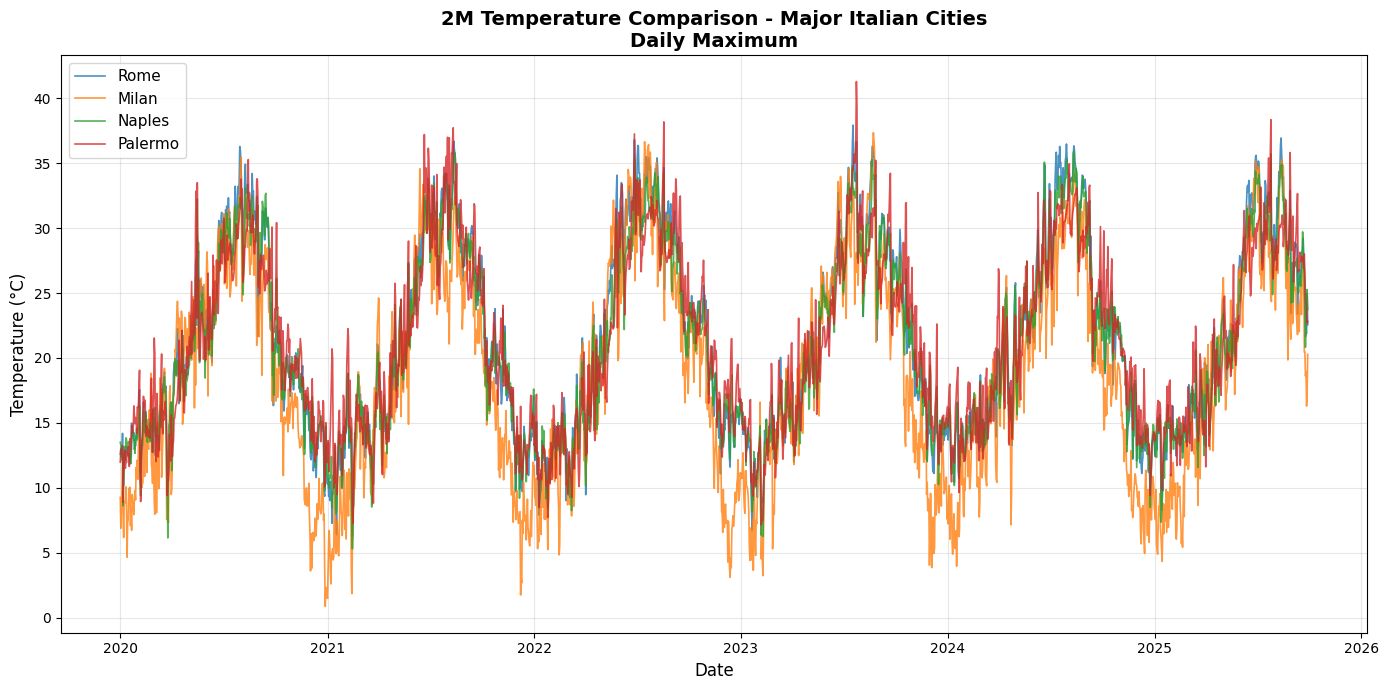

In [23]:
# Extract time series for all cities
city_data = {}
for city_name, coords in cities.items():
    city_ts = era5_var_italy.sel(
        latitude=coords["lat"],
        longitude=coords["lon"],
        method="nearest"
    )
    city_data[city_name] = city_ts

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

ndvi_colors = ['darkred', 'darkblue', 'darkgreen', 'darkorange']
for (city_name, ts), color in zip(city_data.items(), ndvi_colors):
    if voi == "2m_temperature":
        (ts - 273.15).plot(ax=ax, label=city_name, linewidth=1.2, alpha=0.8)
    else:
        ts.plot(ax=ax, label=city_name, linewidth=1.2, alpha=0.8)

ax.set_title(f"{voi.replace('_', ' ').title()} Comparison - Major Italian Cities\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
if voi == "2m_temperature":
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    ax.set_ylabel(f"{voi}", fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We can see that the curve trends for the different cities show similar seasonal patterns, 
with variations in temperature levels due to their geographical locations.

For example, Milan has a generally lower temperature compared to Palermo. Let's visualize this more clearly via a boxplot:

In [24]:
# prepare dataframe for boxplot
series_dict = {city: ts.to_series() for city, ts in city_data.items()}

ts_df = pd.concat(series_dict, names=["city_name", "valid_time"]).reset_index()

# Ensure the data column has the expected name (datavar, e.g. 't2m')
if datavar not in ts_df.columns:
    ts_df = ts_df.rename(columns={ts_df.columns[-1]: datavar})

if voi == "2m_temperature":
    ts_df[datavar] = ts_df[datavar] - 273.15  # Convert to Celsius

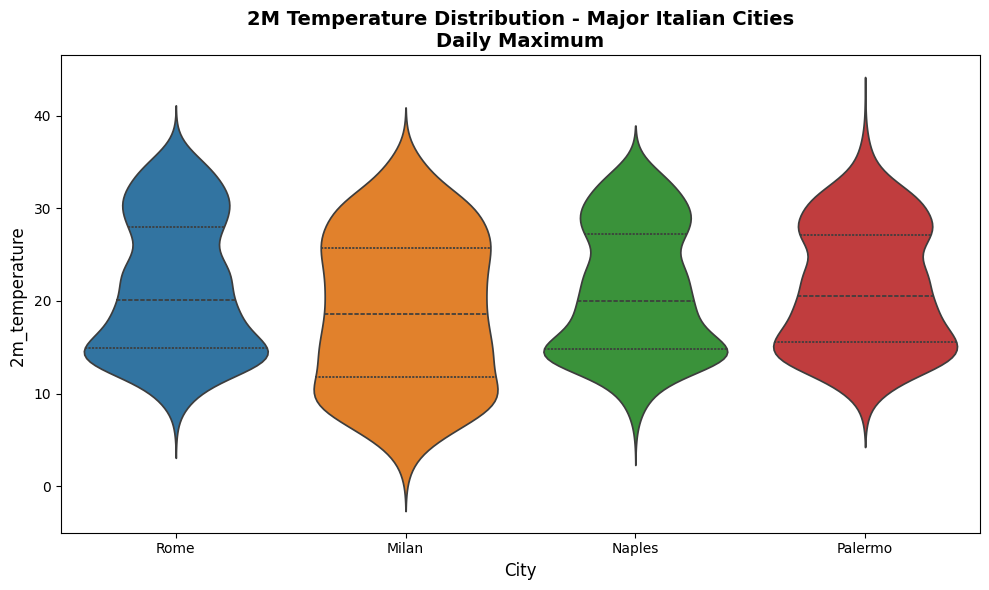

In [25]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(
    x="city_name",
    hue="city_name",
    y=datavar,
    data=ts_df,
    ax=ax,
    inner="quartile",
)
ax.set_ylabel(f"{voi} ", fontsize=12)

ax.set_title(
    f"{voi.replace('_', ' ').title()} Distribution - Major Italian Cities\n{statistic.replace('_', ' ').title()}",
    fontsize=14,
    fontweight="bold",
)
ax.set_xlabel("City", fontsize=12)
plt.tight_layout()
plt.show()

### Spatial-Temporal Statistics

Overall statistics computed by spatial averaging over Italy:

In [26]:
# Calculate spatial mean over all of Italy for each time step
italy_mean = era5_var_italy.mean(dim=['latitude', 'longitude'])

# Calculate temporal statistics
temporal_stats = {
    "Overall Mean": italy_mean.mean().values,
    "Overall Std Dev": italy_mean.std().values,
    "Overall Min": italy_mean.min().values,
    "Overall Max": italy_mean.max().values
}

print("📈 Statistical Summary for Italy (spatially averaged):")
print("="*60)
for stat_name, stat_value in temporal_stats.items():
    if voi == "2m_temperature":
        print(f"{stat_name:20s}: {stat_value:.2f} K ({stat_value-273.15:.2f} °C)")
    else:
        print(f"{stat_name:20s}: {stat_value:.4f}")

📈 Statistical Summary for Italy (spatially averaged):
Overall Mean        : 289.89 K (16.74 °C)
Overall Std Dev     : 7.66 K (-265.49 °C)
Overall Min         : 273.48 K (0.33 °C)
Overall Max         : 305.04 K (31.89 °C)


#### Monthly Aggregation

Resample to monthly means to identify longer-term patterns:

/home/eyad/Progetti/GenHack/.venv/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


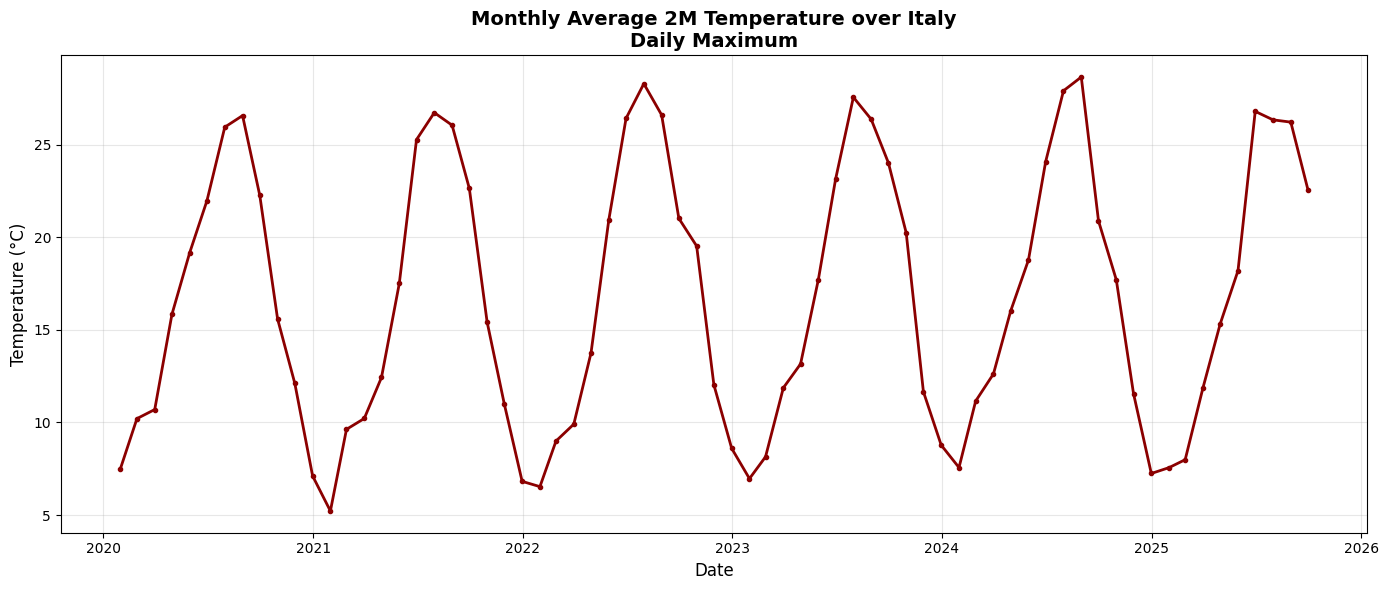

In [27]:
# Resample to monthly means
italy_monthly = italy_mean.resample(valid_time='1M').mean()

# Plot monthly average time series
fig, ax = plt.subplots(figsize=(14, 6))

if voi == "2m_temperature":
    (italy_monthly - 273.15).plot(ax=ax, linewidth=2, marker='o', markersize=3, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    italy_monthly.plot(ax=ax, linewidth=2, marker='o', markersize=3)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"Monthly Average {voi.replace('_', ' ').title()} over Italy\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Seasonal Climatology

Monthly climatology averaged across all years:

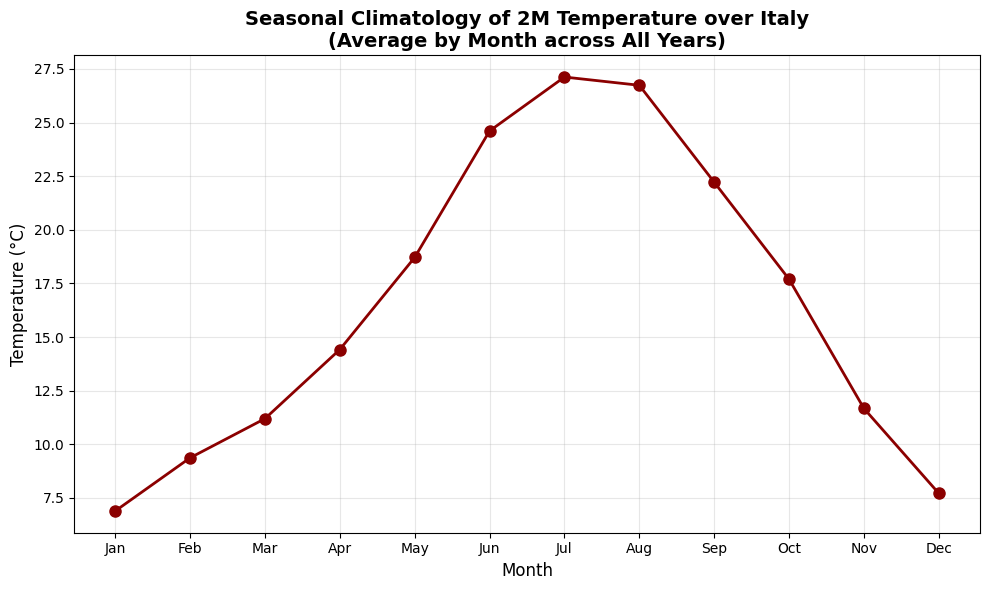

In [28]:
# Group by month and calculate mean
italy_climatology = italy_mean.groupby('valid_time.month').mean()

# Plot seasonal cycle
fig, ax = plt.subplots(figsize=(10, 6))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if voi == "2m_temperature":
    (italy_climatology - 273.15).plot(ax=ax, marker='o', markersize=8, linewidth=2, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    italy_climatology.plot(ax=ax, marker='o', markersize=8, linewidth=2)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"Seasonal Climatology of {voi.replace('_', ' ').title()} over Italy\n(Average by Month across All Years)",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Month", fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## ECA Blend Dataset Exploration

### Dataset Description

The ECA dataset consists of **daily station series** obtained from climatological divisions of National Meteorological and Hydrological Services and station series maintained by observatories and research centres throughout Europe and the Mediterranean.

The series are **quality controlled** and flags (“OK”, “suspect” or “missing”) for individual data are attached.

### Blended Dataset

The series collected from participating countries generally do not contain data for the most recent years. To make available for each station a time series that is as complete as possible, ECA has included an automated update procedure that relies on the daily data from SYNOP messages that are distributed in near real time over the Global Telecommunication System (GTS).

In this procedure the gaps in a daily series are also infilled with observations from nearby stations, provided that they are within 12.5km distance and that height differences are less than 25m.

### CRS Setting

To perform spatial analysis and visualization, we need to select an appropriate Coordinate Reference System (CRS). Unless otherwise specified, we will use EPSG:4326 (WGS 84) for global latitude-longitude coordinates.


In [29]:
std_crs = "WGS84"

### Data Loading

The `stations.txt` file contains metadata for all stations in the ECA dataset.

Analysis considerations:
- Station coordinates are in DMS (Degrees, Minutes, Seconds) format and need to be converted to decimal degrees for analysis.
- Each station has a unique identifier (`STNID`) that can be used to link metadata with the actual climate data files.

In [30]:
stations_path = "../data/ECA_blend_tx/stations.txt"

We need a helper function to convert DMS to decimal degrees.

In [31]:
def dms_to_decimal_vectorized(dms_series):
    """Vectorized DMS to decimal conversion for better performance."""
    # Extract sign
    signs = np.where(dms_series.str[0] == "+", 1, -1)

    # Remove sign and split by ':'
    parts = dms_series.str[1:].str.split(":", expand=True).astype(float)

    # Calculate decimal degrees
    decimal = signs * (parts[0] + parts[1] / 60 + parts[2] / 3600)

    return decimal

We can now load the station metadata and convert coordinates:

In [32]:
stations_df = pd.read_csv(stations_path, skiprows=17, skipinitialspace=True)

# Use vectorized DMS conversion
stations_df["LAT_decimal"] = dms_to_decimal_vectorized(stations_df["LAT"])
stations_df["LON_decimal"] = dms_to_decimal_vectorized(stations_df["LON"])

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["LON_decimal"], stations_df["LAT_decimal"]),
    crs="EPSG:4326",
)
stations_gdf.drop(columns=["LAT", "LON", "LAT_decimal", "LON_decimal"], inplace=True)

stations_gdf.head()

STAID      STANAME                                     CN  HGHT  \
0      1  VAEXJOE                                       SE     166   
1      2  FALUN                                         SE     160   
2      3  STENSELE                                      SE     325   
3      4  LINKOEPING                                    SE      93   
4      5  LINKOEPING-MALMSLAETT                         SE      93   

                    geometry  
0      POINT (14.8 56.86667)  
1  POINT (15.61667 60.61667)  
2  POINT (17.16639 65.06667)  
3      POINT (15.53306 58.4)  
4      POINT (15.53306 58.4)

In [33]:
def read_station_df(path: str) -> pd.DataFrame:
    station_df = pd.read_csv(
        path,
        skiprows=20,
        skipinitialspace=True,
        engine="c",
        parse_dates=["DATE"],
    )
    # Convert DATE column to datetime
    station_df["DATE"] = pd.to_datetime(station_df["DATE"], format="%Y%m%d")

    # Convert from tenths of degree C to degree C
    station_df["TX"] = station_df["TX"] / 10.0

    # Where Q_TX is 9, set TX to NaN
    station_df = station_df[station_df["Q_TX"] == 0]
    station_df.drop(columns=["Q_TX"], inplace=True)

    return station_df


### Data Exploration

#### Geographical Station Distribution

We want to inspect where the stations are located geographically. To do that, we will use again the GADM dataset to provide administrative boundaries for context.

In [34]:
countries_gadms = gadm_gdf.groupby("NAME_0")
print("GADM countries number:", len(countries_gadms))

GADM countries number: 54


To work with the station data spatially, we need to use the same CRS for both datasets.

Let's convert both datasets to EPSG:4326 (WGS 84):

In [35]:
# Convert stations to standard CRS
stations_wdcrs = stations_gdf.to_crs(std_crs)
# Also convert GADM to standard CRS
gadm_gdf_std = gadm_gdf.to_crs(std_crs)

We can now perform a spatial join to associate each station with its corresponding administrative area from the GADM dataset. 

We don't need to be very precise here, since we just want to get a general idea of the station distribution across countries and regions, so we will limit ourselves to country-level associations.

In [36]:
# Optimized spatial join: use pre-converted CRS to avoid repeated conversions
countries_stations = gpd.sjoin(
    stations_wdcrs,
    gadm_gdf_std[['NAME_0', 'geometry']],
    how='inner',
    predicate='within'
)
countries_stations.reset_index()

index  STAID      STANAME                                     CN  HGHT  \
0         0      1  VAEXJOE                                       SE     166   
1         1      2  FALUN                                         SE     160   
2         2      3  STENSELE                                      SE     325   
3         3      4  LINKOEPING                                    SE      93   
4         4      5  LINKOEPING-MALMSLAETT                         SE      93   
...     ...    ...                                           ...   ...   ...   
7492   8563  28070  TRAPANI FONTANASALSA                          IT      57   
7493   8564  28071  TRAPANI FULGATORE                             IT     190   
7494   8565  28072  DUGURDSKAMPEN BH3                             NO    1546   
7495   8566  28075  CANTONIGROS                                   ES     925   
7496   8567  28077  AS NIBIO                                      NO      92   

                       geometry  index_right  NAME_0  
0         POINT (14.8 56.86667)        93460  Sweden  
1     POINT (15.61667 60.61667)        93393  Sweden  
2     POINT (17.16639 65.06667)        93601  Sweden  
3         POINT (15.53306 58.4)        93491  Sweden  
4         POINT (15.53306 58.4)        93491  Sweden  
...                         ...          ...     ...  
7492   POINT (12.5525 37.94167)        70656   Italy  
7493   POINT (12.66139 37.9475)        70656   Italy  
7494   POINT (8.38583 61.69667)        73128  Norway  
7495    POINT (2.40444 42.0425)        90193   Spain  
7496  POINT (10.78167 59.66056)        72859  Norway  

[7497 rows x 8 columns]

Let's see the distribution of stations per country:

In [37]:
# number of stations per country
countries_station_count = (
    countries_stations.groupby("NAME_0")
    .size()
    .rename("num_stations")
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"NAME_0": "country"})  # Rename for consistency
)
countries_station_count.head()

country  num_stations
0    Italy          1111
1  Germany          1041
2    Spain           921
3   Norway           900
4   Sweden           794

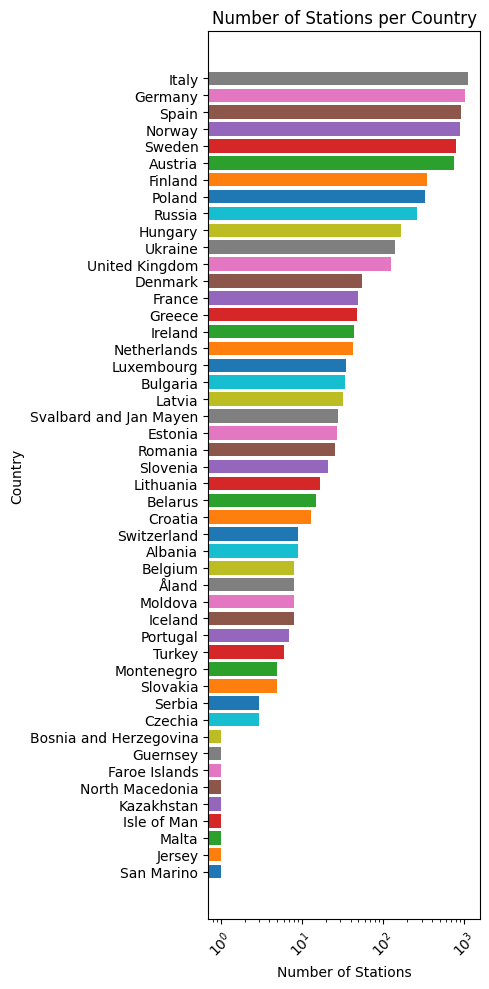

In [38]:
# display a horizontal bar chart of number of stations per country


plt.figure(figsize=(5, 10))
plt.barh(
    countries_station_count["country"][::-1],
    countries_station_count["num_stations"][::-1],
    color=plt.cm.tab10.colors
)

plt.ylabel("Country")
plt.xlabel("Number of Stations")
plt.xscale("log")
plt.title("Number of Stations per Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's now geographically visualize the station distribution overlaid on the GADM country boundaries:

In [39]:
countries_level2_gadm = {}
for country, country_gadm in tqdm(countries_gadms, desc="Processing countries"):
    countries_level2_gadm[country] = country_gadm.dissolve("GID_1", method="coverage")

Processing countries: 100%|██████████| 54/54 [00:17<00:00,  3.14it/s]


100%|██████████| 54/54 [02:10<00:00,  2.42s/it]


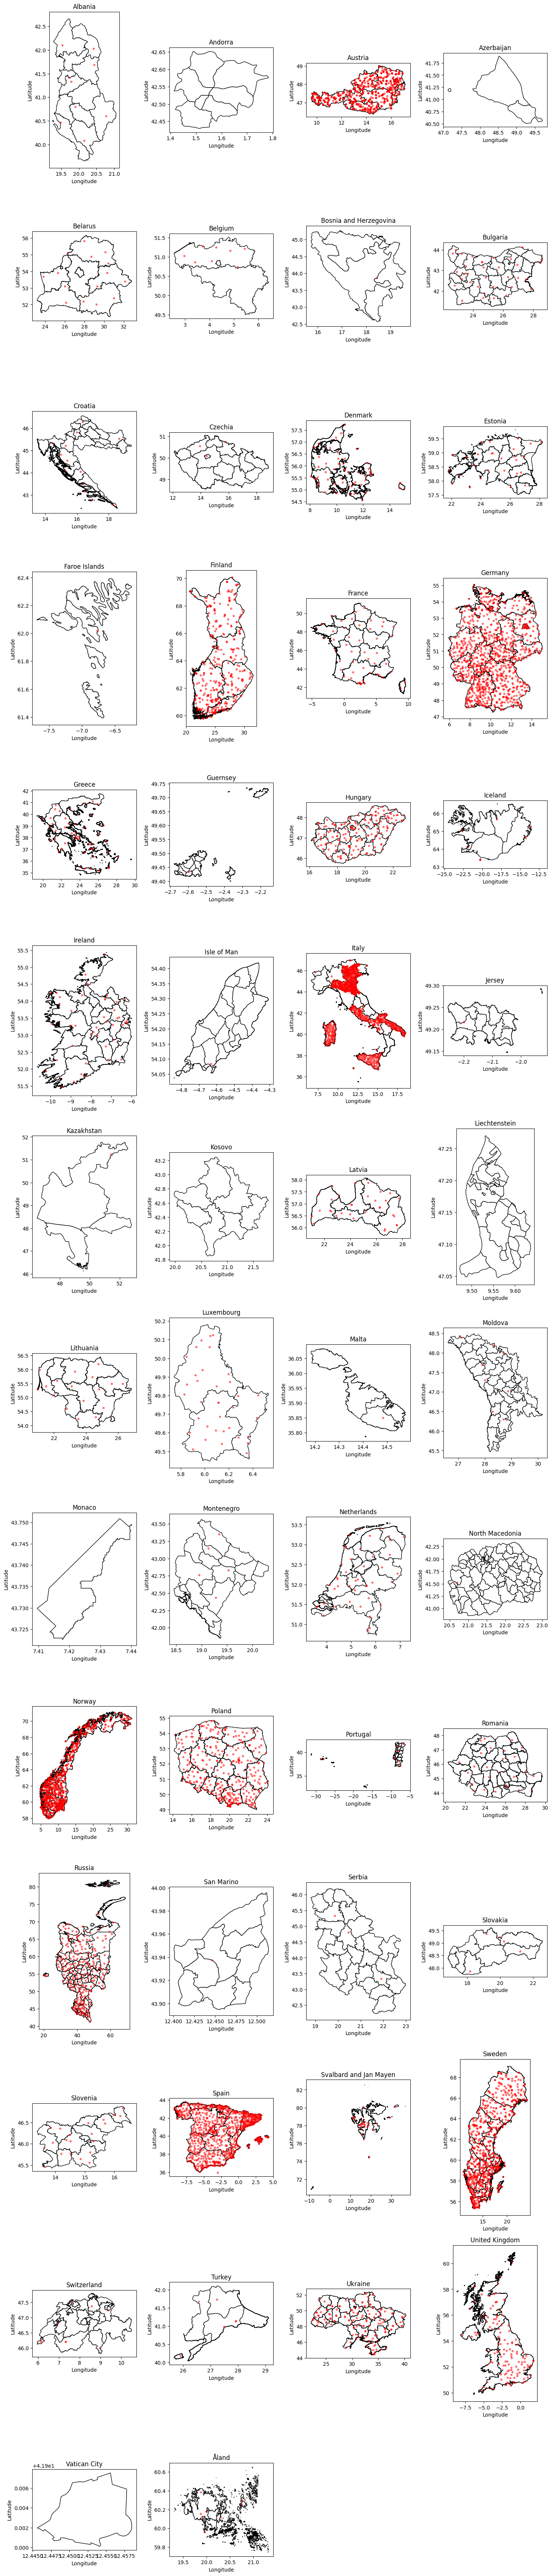

In [40]:
ncols = 4
nrows = int(np.ceil(len(countries_level2_gadm) / ncols))

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axis = axis.flatten()

# Pre-filter countries_stations by country for efficiency
countries_stations_dict = {
    country: countries_stations[countries_stations['NAME_0'] == country]
    for country in countries_level2_gadm.keys()
}

for i, (country, level2_gadm) in tqdm(
    enumerate(countries_level2_gadm.items()), total=len(countries_level2_gadm)
):
    ax = axis[i]
    level2_gadm.plot(color="white", edgecolor="black", ax=ax)

    # Use pre-filtered data
    country_data = countries_stations_dict[country]
    ax.scatter(
        country_data["geometry"].x,
        country_data["geometry"].y,
        color="red",
        s=10,
        alpha=0.5,
    )

    ax.set_title(country)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

for j in range(i + 1, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

As seen from the map, the stations are not evenly distributed across Europe. Some countries have a higher density of stations, while others have fewer stations.

Some countries, such as Italy, have a particularly high density of stations in some regions, while having no stations in others.

#### Country Selection Criteria

To make our analysis more meaningful, we consider an index of station density, defined as the number of stations per 1,000 square kilometers for each country.

In [41]:
# Optimize area calculation: dissolve is already done in countries_level2_gadm
countries_sizes = pd.DataFrame({
    "country": list(countries_level2_gadm.keys()),
    "size_km2": [
        country_gadm.to_crs(epsg=3395).geometry.area.sum() / 1e6
        for country_gadm in countries_level2_gadm.values()
    ]  # convert from m^2 to km^2
})
countries_sizes.head()

country       size_km2
0     Albania   50520.198698
1     Andorra     828.494569
2     Austria  183910.100912
3  Azerbaijan   16450.861161
4     Belarus  584634.793119

In [42]:
countries_stations_size = countries_station_count.merge(
    countries_sizes, on="country", how="left"
)

countries_stations_size["stations_per_1000_km2"] = (
    countries_stations_size["num_stations"] / countries_stations_size["size_km2"]
) * 1000.0

countries_stations_size.sort_values(
    "stations_per_1000_km2", inplace=True, ascending=False
)

countries_stations_size.head()

country  num_stations       size_km2  stations_per_1000_km2
47  San Marino             1     117.679168               8.497681
17  Luxembourg            35    6166.459452               5.675866
40    Guernsey             1     208.777590               4.789786
5      Austria           763  183910.100912               4.148766
46      Jersey             1     292.172761               3.422633

For the moment, we decide to focus on countries that meet the following criteria:

- Minimum 100 stations (data density)
- Area > 500,000 km² (regional representativeness)
- Ranked by station density (stations per 1000 km²)


In [43]:
selected_countries = (
    countries_stations_size[
        (countries_stations_size["num_stations"] > 100)
        & (countries_stations_size["size_km2"] > 500_000)
    ]
    .iloc[:10]
    .reset_index(drop=True)
)

In [44]:
print("Countries selected for the analysis:")
display(selected_countries)
print(f"Total area (km^2): {selected_countries['size_km2'].sum():_.0f} km^2")

Countries selected for the analysis:


country  num_stations      size_km2  stations_per_1000_km2
0           Italy          1111  5.589442e+05               1.987676
1         Germany          1041  9.065714e+05               1.148282
2           Spain           921  8.583977e+05               1.072929
3          Norway           900  1.789487e+06               0.502937
4          Poland           334  8.267868e+05               0.403974
5          Sweden           794  2.178067e+06               0.364543
6         Finland           355  1.828697e+06               0.194127
7  United Kingdom           126  7.158318e+05               0.176019
8         Ukraine           141  1.395034e+06               0.101073
9          Russia           265  1.598131e+07               0.016582

Total area (km^2): 27_039_129 km^2


#### Selected Stations Data Loading

In [45]:
# Filter countries_stations efficiently using isin
selected_stations = countries_stations[
    countries_stations["NAME_0"].isin(selected_countries["country"])
].reset_index(drop=True)

assert selected_stations.shape[0] == selected_countries["num_stations"].sum(), (
    "Number of selected stations does not match the sum of stations in selected countries."
)

print("Number of selected stations:", selected_stations.shape[0])
selected_stations.head()

Number of selected stations: 5988


STAID      STANAME                                     CN  HGHT  \
0      1  VAEXJOE                                       SE     166   
1      2  FALUN                                         SE     160   
2      3  STENSELE                                      SE     325   
3      4  LINKOEPING                                    SE      93   
4      5  LINKOEPING-MALMSLAETT                         SE      93   

                    geometry  index_right  NAME_0  
0      POINT (14.8 56.86667)        93460  Sweden  
1  POINT (15.61667 60.61667)        93393  Sweden  
2  POINT (17.16639 65.06667)        93601  Sweden  
3      POINT (15.53306 58.4)        93491  Sweden  
4      POINT (15.53306 58.4)        93491  Sweden

Now we can proceed with loading the actual temperature data for the selected countries.

To do that we want to first load all the station data files. To do that, we could iterate over the selected stations and read their corresponding data files.

For your convenience, we already did that and saved the combined data for the selected countries into a single Parquet file named `../processed/selected_countries_tx_data.parquet`.

If you don't have that file, you can uncomment and run the following code to generate it.

In [46]:
# eca_tx_datafolder = "../data/ECA_blend_tx/"

# station_paths = [
#     os.path.join(eca_tx_datafolder, f"TX_STAID{id:06d}.txt")
#     for id in selected_stations["STAID"]
# ]

# stations_list = [read_station_df(path) for path in tqdm.tqdm(station_paths)]

# region_station_data = pd.concat(stations_list, ignore_index=True)
# region_station_data.to_parquet("../processed/selected_countries_tx_data.parquet")

# print(f"Total number of records for region {gadm_filter}: {len(region_station_data)}")
# display(region_station_data.head())

We can now read back the combined data for the selected countries:

In [47]:
region_station_data = pd.read_parquet("../processed/selected_countries_tx_data.parquet")

print(f"Total number of records for selected region: {len(region_station_data)}")
display(region_station_data.head())

Total number of records for selected region: 83561206


STAID   SOUID       DATE    TX
0    170  916133 2005-12-01   7.7
1    170  916133 2005-12-02   6.2
2    170  916133 2005-12-03  10.6
3    170  916133 2005-12-04   6.2
4    170  916133 2005-12-05   7.1

In [48]:
# oldest and newest date
min_date = region_station_data["DATE"].min()
max_date = region_station_data["DATE"].max()

print(f"Data coverage from {min_date.date()} to {max_date.date()} ({(max_date - min_date).days} days)")

Data coverage from 1763-01-01 to 2025-08-31 (95936 days)


#### Coverage Analysis

We can display the temporal coverage of the temperature data for the selected stations.

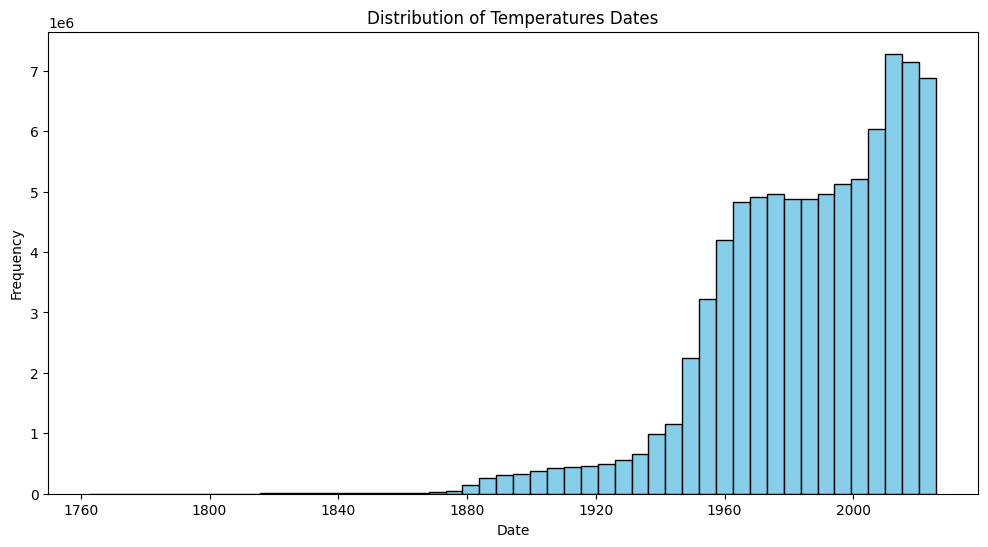

In [49]:
# analyze the tx time distribution
plt.figure(figsize=(12, 6))
plt.hist(region_station_data["DATE"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Temperatures Dates")
plt.show()

In [50]:
# how many records for each station
station_record_counts = region_station_data.groupby("STAID").size()

# display stations with more than 1000 records and less than 60000 records
non_outlier_stations = station_record_counts[
    (station_record_counts >= 1000) & (station_record_counts <= 60000)
]

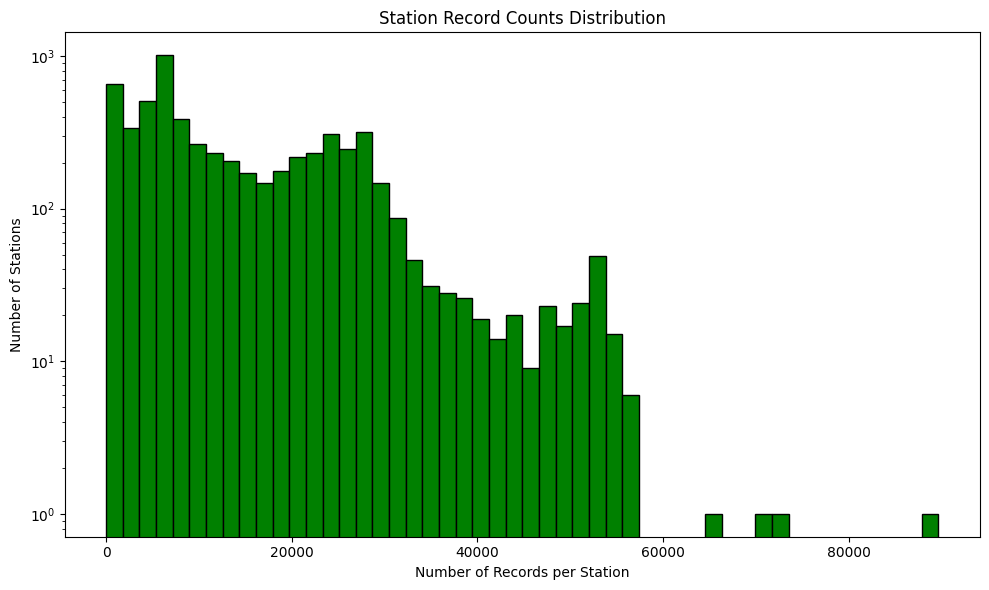

In [51]:
plt.figure(figsize=(10, 6))
plt.hist(
    station_record_counts,
    bins=50,
    color="green",
    edgecolor="black",
)
plt.yscale("log")
plt.xlabel("Number of Records per Station")
plt.ylabel("Number of Stations")
plt.title("Station Record Counts Distribution")
plt.tight_layout()
plt.show()

The data shows that data is available from the early 20th century up to recent years, with varying coverage across different stations.

#### Filter to significant time period (2000+)

We can filter the data to focus on a more recent and significant time period, such as from 2000 onwards.

In [52]:
selected_tx_data = region_station_data[region_station_data["DATE"] >= "2000-01-01"]
print(f"Total number of records from 2000 onwards: {len(selected_tx_data):_}")

Total number of records from 2000 onwards: 31_959_017


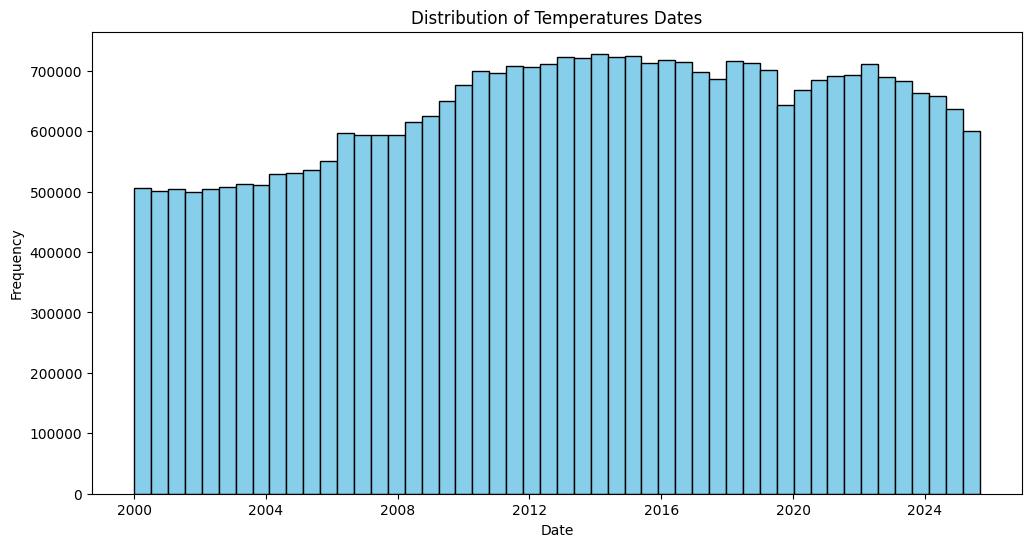

In [53]:
# analyze the tx time distribution
plt.figure(figsize=(12, 6))
plt.hist(selected_tx_data["DATE"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Temperatures Dates")
plt.show()

## NDVI Dataset Exploration

The Normalized Difference Vegetation Index (NDVI) is a widely used remote sensing index that quantifies vegetation health and density using satellite imagery.

It normalizes green leaf scattering in Near Infra-red wavelengths with chlorophyll absorption in red wavelengths.

- Negative values of NDVI (values approaching -1) correspond to water;
- Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow;
- Low, positive values represent shrub and grassland (approximately 0.2 to 0.4);
- High values indicate temperate and tropical rainforests (values approaching 1).

The Sentinel-2 mission provides high-resolution optical imagery that can be used to compute NDVI.


In [54]:
import os.path

ndvi_data_dir = os.path.join(data_dir, "sentinel2_ndvi")
ndvi_data_dir

'../data/sentinel2_ndvi'

### Data Loading

The dataset is provided in GeoTIFF format, which is a standard format for storing geospatial raster data. In this format each pixel in the image corresponds to a specific geographic location and contains a value representing the NDVI at that location.

#### Coordinate Reference System

A Coordinate Reference System (CRS) is necessary to accurately map the raster data to real-world locations. The Sentinel-2 NDVI data uses the UTM (Universal Transverse Mercator) projection system, which divides the Earth into a series of zones, each with its own coordinate system.


In [55]:
import rasterio
import glob

ndvi_paths = glob.glob(os.path.join(ndvi_data_dir, "*.tif"))

with rasterio.open(ndvi_paths[0], "r") as f:
    ndvi_meta = f.meta


display(ndvi_meta)

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 61776,
 'height': 52389,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]'),
 'transform': Affine(80.0, 0.0, 2515045.4445281317,
        0.0, -80.0, 5538861.439101856)}

The CRS for the Sentinel-2 NDVI data is the EPSG:3035 — ETRS89 / LAEA Europe, a Lambert Azimuthal Equal-Area projection commonly used for pan-European spatial analysis.

#### Pixel Value Interpretation

Although NDVI values theoretically range from -1 to 1, in practice, the values in the Sentinel-2 NDVI dataset are often scaled to a different range for storage efficiency. 

In our case, the NDVI values are scaled to the range of 0 to 255, where:
- 0 corresponds to an NDVI value of -1
- 254 corresponds to an NDVI value of 1
- 255 is used to represent nodata values.

### Data Analysis

Let's now try to load a sample NDVI GeoTIFF file and display it. We can use the `rasterio` library to read the file and `matplotlib` to visualize it.

To not fill the memory, we will load only a small portion of the image by specifying a window.

In [56]:
ndvi_example_path = ndvi_paths[0]

In [57]:
from rasterio.mask import mask as rio_mask

def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in int8 format on a 0/254 scale, and nodata is 255.
    # This function converts it to a float format on a -1/1 scale, and replace nodata with np.nan.
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 254 * 2 - 1
    return ndvi_img

def get_out_image_and_metadata(filepath, one_city_gdf):
    with rasterio.open(filepath) as src:
        one_city_gdf_in_good_crs = one_city_gdf.to_crs(src.crs)
        city_geometry = [one_city_gdf_in_good_crs.geometry.iloc[0]]
        out_image, out_transform = rio_mask(src, city_geometry, crop=True)
        out_meta = src.meta

        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

    return real_out_image, out_meta

To display the NDVI values correctly, we need to create a custom colormap that maps -1 to blue, 0 to white, and 1 to green.

In [58]:
from matplotlib.colors import LinearSegmentedColormap

ndvi_colors = ["blue", "white", "green"]
ndvi_cmap = LinearSegmentedColormap.from_list("GreenBlue", ndvi_colors)
ndvi_cmap.set_bad(color="lightgray")

#### Emilia-Romagna

Let's now display the Emilia-Romagna region NDVI sample.

GC collected objects : 24155


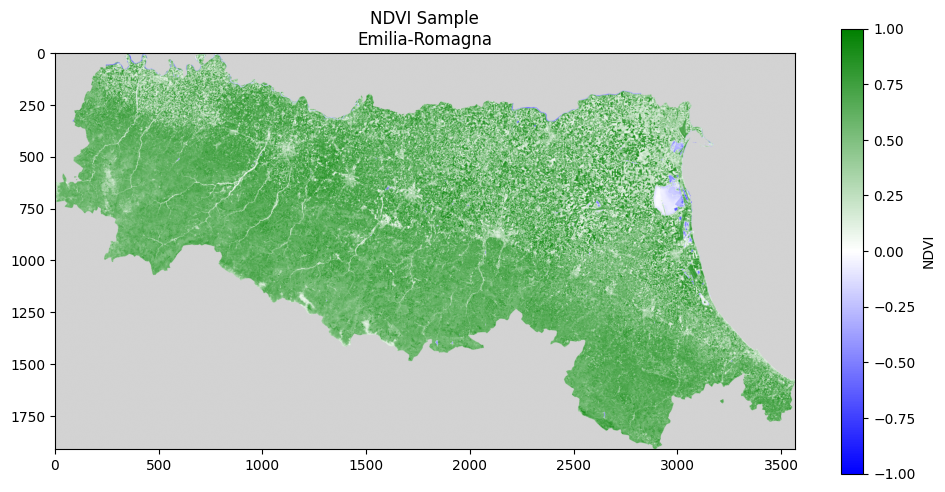

In [59]:
import matplotlib.pyplot as plt
import gc

print("GC collected objects :", gc.collect())

emilia_romagna = gadm_gdf[gadm_gdf["NAME_1"] == "Emilia-Romagna"].dissolve()
ndvi_sample_emilia_romagna, _ = get_out_image_and_metadata(
    ndvi_example_path, emilia_romagna
)


plt.figure(figsize=(10, 5))
plt.imshow(ndvi_sample_emilia_romagna[0], cmap=ndvi_cmap, vmin=-1, vmax=1)
plt.title("NDVI Sample\nEmilia-Romagna")
plt.colorbar(label="NDVI")
plt.tight_layout()
plt.show()


We can see that the color mapping correctly represents the NDVI values, with blue indicating water bodies, white for barren areas, and green for dense vegetation.

#### Lakes

Let's now do the same for two of the most important Italian lakes: Lago di Como and Lago Trasimeno.

GC collected objects : 5972
NDVI Sample shape: (1, 838, 494)


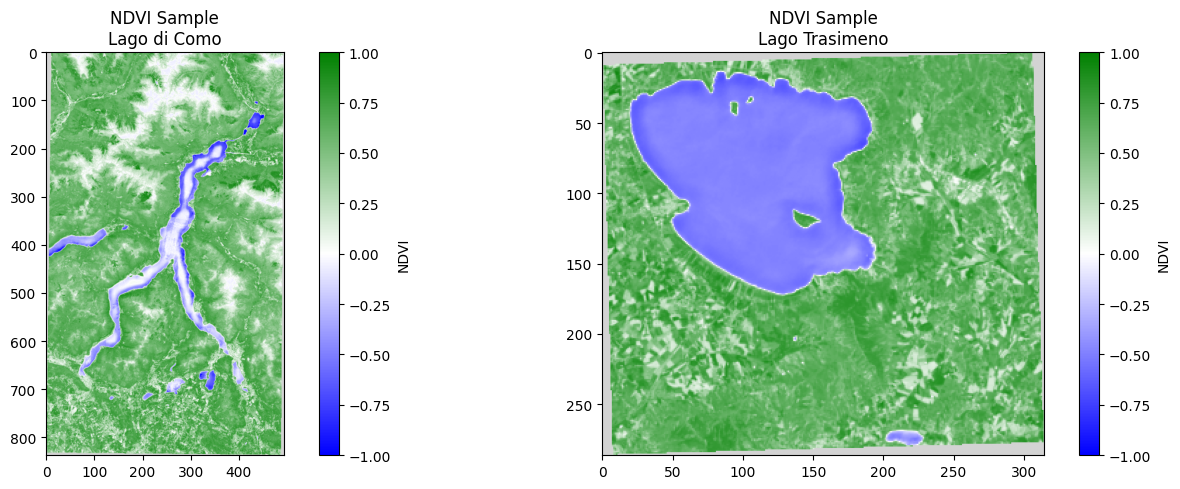

In [60]:
import matplotlib.pyplot as plt
import gc
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import box

print("GC collected objects :", gc.collect())


lago_di_como = (
    gadm_gdf[
        (gadm_gdf["NAME_0"] == "Italy")
        & ((gadm_gdf["NAME_1"] == "Veneto") | (gadm_gdf["NAME_1"] == "Lombardia"))
    ]
    .reset_index(drop=True)
    .dissolve(by="GID_0", method="coverage")
)


# Bounding box del Lago di Como
lago_di_como = gpd.GeoDataFrame(geometry=[box(9, 45.7, 9.5, 46.3)], crs="EPSG:4326")
lago_trasimeno = gpd.GeoDataFrame(
    geometry=[box(12.0, 43.0, 12.3, 43.2)], crs="EPSG:4326"
)

ndvi_sample_lago_di_como, _ = get_out_image_and_metadata(
    ndvi_example_path, lago_di_como
)
ndvi_sample_lago_trasimeno, _ = get_out_image_and_metadata(
    ndvi_example_path, lago_trasimeno
)

print(f"NDVI Sample shape: {ndvi_sample_lago_di_como.shape}")

fig, axis = plt.subplots(1, 2, figsize=(15, 5))
axis[0].imshow(ndvi_sample_lago_di_como[0], cmap=ndvi_cmap, vmin=-1, vmax=1)
fig.colorbar(
    axis[0].imshow(ndvi_sample_lago_di_como[0], cmap=ndvi_cmap, vmin=-1, vmax=1),
    ax=axis[0],
    label="NDVI",
)
axis[0].set_title("NDVI Sample\nLago di Como")


axis[1].imshow(ndvi_sample_lago_trasimeno[0], cmap=ndvi_cmap, vmin=-1, vmax=1)
fig.colorbar(
    axis[1].imshow(ndvi_sample_lago_trasimeno[0], cmap=ndvi_cmap, vmin=-1, vmax=1),
    ax=axis[1],
    label="NDVI",
)
axis[1].set_title("NDVI Sample\nLago Trasimeno")

plt.tight_layout()
plt.show()

We can see that a significant portion of both lakes is represented by blue colors, indicating water bodies with low or negative NDVI values. 

On the Lago di Como, additionally, we can observe some areas with higher NDVI values inside the lake. This could be due to the presence of atmospheric effects that influenced the reflectance values recorded by the satellite, leading to anomalous NDVI readings in those areas.

This can be seen in more detail if we zoom in.

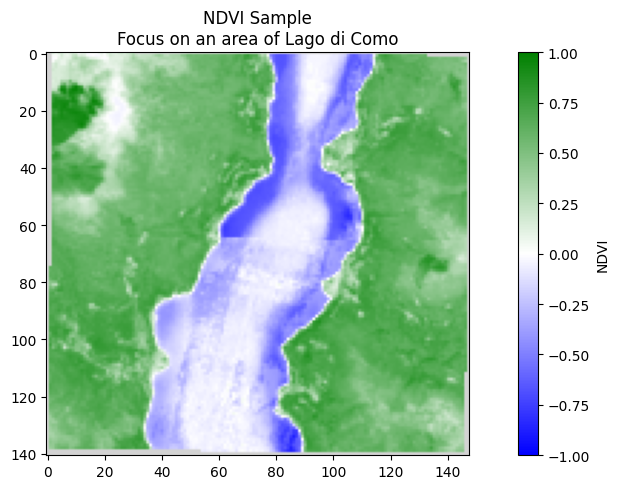

In [61]:
laghi_bassi = box(9.2, 46, 9.35, 46.1)

plt.figure(figsize=(10, 5))
nvdi_sample, _ = get_out_image_and_metadata(
    ndvi_example_path, gpd.GeoDataFrame(geometry=[laghi_bassi], crs="EPSG:4326")
)
plt.imshow(nvdi_sample[0], cmap=ndvi_cmap, vmin=-1, vmax=1)
plt.title("NDVI Sample\nFocus on an area of Lago di Como")
plt.colorbar(label="NDVI")
plt.tight_layout()
plt.show()


## ECA Blend vs ERA5-Land Temperature Analysis

We will now try to compare the temperature data from the ECA Blend dataset with the ERA5-Land dataset for the region of Bologna, Italy.

In [62]:
bologna_gadm = gadm_gdf[gadm_gdf["NAME_2"] == "Bologna"]
bologna_ndvi, _ = get_out_image_and_metadata(
    ndvi_example_path, bologna_gadm
)

bologna_stations = stations_wdcrs.sjoin(
    bologna_gadm, how="inner", predicate="within"
)

print(f"Number of stations in Bologna area: {len(bologna_stations)}")
bologna_stations.head()

Number of stations in Bologna area: 60


STAID      STANAME                                     CN  HGHT  \
471     861  MONZUNO                                       IT     600   
472     862  PORRETTA TERME                                IT     352   
1158   2791  CASTEL DEL RIO                                IT     216   
1167   2804  COTTEDE                                       IT     794   
1168   2805  DIGA DEL BRASIMONE                            IT     846   

                       geometry  index_right     UID GID_0 NAME_0    GID_1  \
471   POINT (11.27333 44.27667)        65631  188323   ITA  Italy  ITA.6_1   
472   POINT (10.97694 44.15417)        65636  188328   ITA  Italy  ITA.6_1   
1158    POINT (11.505 44.21083)        65601  188293   ITA  Italy  ITA.6_1   
1167  POINT (11.16917 44.10944)        65609  188301   ITA  Italy  ITA.6_1   
1168  POINT (11.11778 44.12917)        65597  188289   ITA  Italy  ITA.6_1   

      ...                  NAME_3 ENGTYPE_3 GID_4 NAME_4 ENGTYPE_4 GID_5  \
471   ...                 Monzuno   Commune                                
472   ...          Porretta Terme   Commune                                
1158  ...          Castel Del Rio   Commune                                
1167  ...  Castiglione Dei Pepoli   Commune                                
1168  ...               Camugnano   Commune                                

     NAME_5 ENGTYPE_5 COUNTRY CONTINENT  
471                     Italy    Europe  
472                     Italy    Europe  
1158                    Italy    Europe  
1167                    Italy    Europe  
1168                    Italy    Europe  

[5 rows x 26 columns]

We can now display each station on the map of Bologna area:

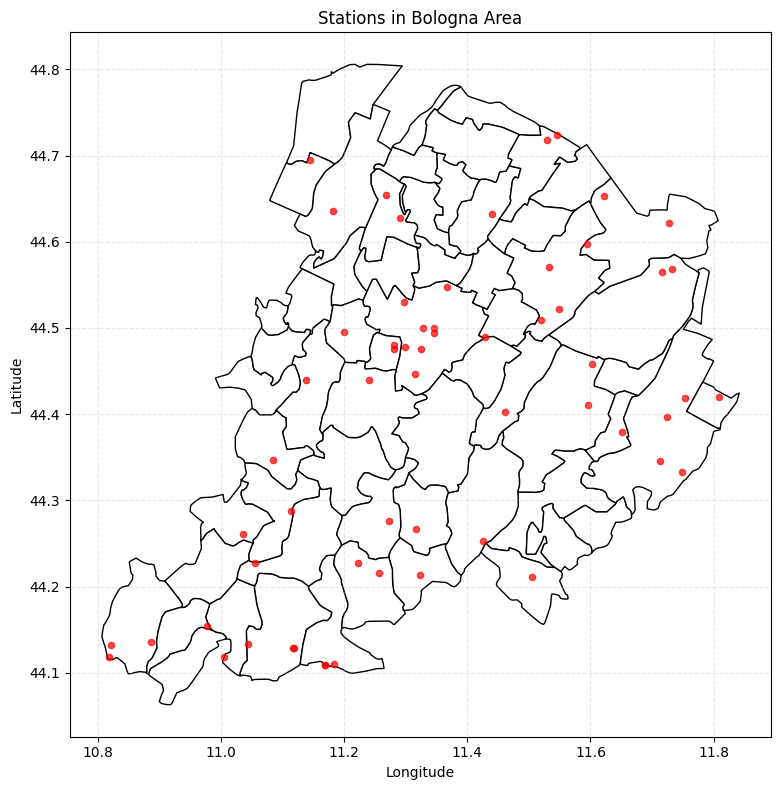

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
bologna_gadm.plot(ax=plt.gca(), color="white", edgecolor="black")
plt.scatter(
    bologna_stations.geometry.x,
    bologna_stations.geometry.y,
    color="red",
    s=20,
    alpha=0.7,
)


plt.title("Stations in Bologna Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [64]:
bologna_stations_paths = [
    os.path.join(data_dir, "ECA_blend_tx", f"TX_STAID{stid:06d}.txt")
    for stid in bologna_stations["STAID"]
]

bologna_stations_list = [
    read_station_df(path) for path in tqdm(bologna_stations_paths, desc="Reading station data")
]

bologna_station_data = pd.concat(bologna_stations_list, ignore_index=True)
print(f"Total number of records for Bologna area: {len(bologna_station_data)}")
bologna_station_data.head()

Reading station data: 100%|██████████| 60/60 [00:01<00:00, 45.47it/s]

Total number of records for Bologna area: 359147


STAID  SOUID       DATE   TX
0    861  96202 2006-01-02  1.2
1    861  96202 2006-01-03  4.0
2    861  96202 2006-01-04  5.1
3    861  96202 2006-01-05  1.0
4    861  96202 2006-01-06  3.0

Instead of a long list of records, we find more value in pivoting the data to have dates as rows and stations as columns.

In [65]:
bologna_temp_per_date = bologna_station_data.pivot(
    index="DATE", columns="STAID", values="TX"
)
bologna_temp_per_date.head()

STAID       861    862    2791   2804   2805   2807   2809   2822   2830   \
DATE                                                                        
2005-12-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

STAID       2844   ...  17813  17845  17850  17855  17861  17862  17867  \
DATE               ...                                                    
2005-12-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-02    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-03    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-04    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005-12-05    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

STAID       17873  17879  21781  
DATE                             
2005-12-01    NaN    NaN    NaN  
2005-12-02    NaN    NaN    NaN  
2005-12-03    NaN    NaN    NaN  
2005-12-04    NaN    NaN    NaN  
2005-12-05    NaN    NaN    NaN  

[5 rows x 60 columns]

To have a look at the data coverage per station, we need to select a date first.

In [66]:
bologna_day = "2020-10-15"

In [67]:
real_day_temp = bologna_temp_per_date[bologna_day:bologna_day]
real_day_temp = real_day_temp.T.dropna()
real_day_temp.columns = ["TX"]
real_day_temp.head()

TX
STAID      
862    11.1
2791   12.6
2804    7.7
2805    7.5
2807    9.8

To visualize the result, we re-join the station temperatures with their geometries.

In [68]:
real_day_temp_with_coord = bologna_stations.join(
    real_day_temp,
    on="STAID",
    how="inner",
)
real_day_temp_with_coord.head()

STAID      STANAME                                     CN  HGHT  \
472     862  PORRETTA TERME                                IT     352   
1158   2791  CASTEL DEL RIO                                IT     216   
1167   2804  COTTEDE                                       IT     794   
1168   2805  DIGA DEL BRASIMONE                            IT     846   
1170   2807  DIGA DI PAVANA                                IT     480   

                       geometry  index_right     UID GID_0 NAME_0    GID_1  \
472   POINT (10.97694 44.15417)        65636  188328   ITA  Italy  ITA.6_1   
1158    POINT (11.505 44.21083)        65601  188293   ITA  Italy  ITA.6_1   
1167  POINT (11.16917 44.10944)        65609  188301   ITA  Italy  ITA.6_1   
1168  POINT (11.11778 44.12917)        65597  188289   ITA  Italy  ITA.6_1   
1170  POINT (11.00556 44.11806)        65602  188294   ITA  Italy  ITA.6_1   

      ... ENGTYPE_3 GID_4 NAME_4 ENGTYPE_4 GID_5 NAME_5 ENGTYPE_5 COUNTRY  \
472   ...   Commune                                                 Italy   
1158  ...   Commune                                                 Italy   
1167  ...   Commune                                                 Italy   
1168  ...   Commune                                                 Italy   
1170  ...   Commune                                                 Italy   

     CONTINENT    TX  
472     Europe  11.1  
1158    Europe  12.6  
1167    Europe   7.7  
1168    Europe   7.5  
1170    Europe   9.8  

[5 rows x 27 columns]

#### Creating Temperature Grid from Station Data

To create a temperature grid from the station data, we can use spatial interpolation techniques. Here, we will use Nearest Neighbor interpolation for simplicity.

We can choose the scale such that two stations will not fall into the same grid cell. To do that we first determine the minimum distance between stations and then set the grid resolution accordingly.

In [69]:
bologna_stations_geometry = real_day_temp_with_coord[["STAID", "geometry"]]
bologna_stations_geometry.head()

STAID                   geometry
472     862  POINT (10.97694 44.15417)
1158   2791    POINT (11.505 44.21083)
1167   2804  POINT (11.16917 44.10944)
1168   2805  POINT (11.11778 44.12917)
1170   2807  POINT (11.00556 44.11806)

In [70]:
from scipy.spatial import distance_matrix

coords = np.array([(geom.x, geom.y) for geom in bologna_stations_geometry.geometry])

dist_matrix = distance_matrix(coords, coords)

stations_distances = pd.DataFrame(
    dist_matrix,
    index=bologna_stations_geometry["STAID"],
    columns=bologna_stations_geometry["STAID"],
)

stations_distances.head()

STAID     862       2791      2804      2805      2807      2809      2822   \
STAID                                                                         
862    0.000000  0.531087  0.197356  0.143035  0.046072  0.069070  0.760316   
2791   0.531087  0.000000  0.350804  0.395740  0.507989  0.468263  0.247632   
2804   0.197356  0.350804  0.000000  0.055043  0.163838  0.128511  0.592673   
2805   0.143035  0.395740  0.055043  0.000000  0.112771  0.074889  0.633126   
2807   0.046072  0.507989  0.163838  0.112771  0.000000  0.040814  0.742913   

STAID     2830      2844      2916   ...     17800     17801     17811  \
STAID                                ...                                 
862    0.789253  0.328354  0.190731  ...  0.820894  0.785673  0.554300   
2791   0.507798  0.432774  0.399426  ...  0.324574  0.287526  0.364387   
2804   0.707112  0.332293  0.186952  ...  0.661686  0.625045  0.481140   
2805   0.718353  0.311771  0.158681  ...  0.699098  0.662882  0.487393   
2807   0.796347  0.348401  0.200903  ...  0.806642  0.770831  0.561696   

STAID     17850     17855     17862     17867     17873     17879     21781  
STAID                                                                        
862    0.408032  0.446120  0.760327  0.107885  0.846287  0.197419  0.163300  
2791   0.417433  0.349755  0.397148  0.449774  0.412836  0.350885  0.693621  
2804   0.387617  0.387257  0.647557  0.164244  0.712419  0.000278  0.351793  
2805   0.375772  0.387226  0.668437  0.116836  0.740851  0.055144  0.300454  
2807   0.424882  0.455237  0.759555  0.120830  0.840052  0.163852  0.188057  

[5 rows x 53 columns]

Now let's calculated the minimum distance between stations:

In [71]:
degrees_per_km = 1 / 111  # Approximate conversion factor

min_station_distance = stations_distances.replace(0, np.nan).min().min()
print(f"Minimum distance between stations: {min_station_distance} degrees -> {min_station_distance / degrees_per_km:.2f} km")

Minimum distance between stations: 0.0002777777777822621 degrees -> 0.03 km


To create the grid, we first define the bounding box, based on the GADM boundaries for Bologna. Then we split the bounding box into a grid of cells with the determined width and height.

In [72]:
bologna_geom = bologna_gadm.dissolve().geometry
bologna_start_lat = bologna_geom.bounds.iloc[0]["miny"]
bologna_end_lat = bologna_geom.bounds.iloc[0]["maxy"]
bologna_start_lon = bologna_geom.bounds.iloc[0]["minx"]
bologna_end_lon = bologna_geom.bounds.iloc[0]["maxx"]

print(
    f"Region bounds:\n\tLongitude: {bologna_start_lon} to {bologna_end_lon}\n\tLatitude: {bologna_start_lat} to {bologna_end_lat}"
)

x_distance = bologna_end_lon - bologna_start_lon
y_distance = bologna_end_lat - bologna_start_lat

print("Region size:")
print(f"\tx distance: {x_distance} degrees")
print(f"\ty distance: {y_distance} degrees")


Region bounds:
	Longitude: 10.806600572000036 to 11.841407777000029
	Latitude: 44.06320953500011 to 44.80568695200009
Region size:
	x distance: 1.0348072049999928 degrees
	y distance: 0.742477416999975 degrees


In [73]:
# We want to have at most one station per pixel.
# Given the minimum distance between stations, we can compute the required resolution.

pixels_per_degree = np.ceil(1 / min_station_distance).astype(int)
print(f"Pixels per degree: {pixels_per_degree}")

required_x_pixels = int(x_distance * pixels_per_degree)
required_y_pixels = int(y_distance * pixels_per_degree)

print(
    f"Required pixels: {required_x_pixels * required_y_pixels:,}"
    " ({required_x_pixels}x{required_y_pixels} pixels)"
)

Pixels per degree: 3600
Required pixels: 9,953,200 ({required_x_pixels}x{required_y_pixels} pixels)


Then we use cKDTree from scipy to perform Nearest Neighbor interpolation and assign temperature values to each grid cell based on the nearest station.

In [74]:
import tqdm
from scipy.spatial import cKDTree

grid = np.full((required_y_pixels, required_x_pixels), np.nan)

bologna_station_coords = []
bologna_station_values = []

# populate with station data
for idx, row in real_day_temp_with_coord.iterrows():
    station_lon = row.geometry.x
    station_lat = row.geometry.y
    station_tx = row.TX

    # compute pixel indices
    x_idx = int((station_lon - bologna_start_lon) / x_distance * required_x_pixels)
    y_idx = int((station_lat - bologna_start_lat) / y_distance * required_y_pixels)

    grid[y_idx, x_idx] = station_tx
    bologna_station_coords.append([y_idx, x_idx])
    bologna_station_values.append(row.TX)

bologna_station_coords = np.array(bologna_station_coords)
bologna_station_values = np.array(bologna_station_values)
# Build KDTree for fast nearest neighbor lookup
kdtree = cKDTree(bologna_station_coords)

# Vectorized approach: find all NaN pixels at once
nan_mask = np.isnan(grid)
nan_indices = np.argwhere(nan_mask)

if len(nan_indices) > 0:
    # Query the KDTree for nearest neighbors
    distances, indices = kdtree.query(nan_indices)

    # Fill in the NaN values
    for (i, j), station_idx in tqdm.tqdm(zip(nan_indices, indices), total=len(nan_indices)):

        grid[i, j] = bologna_station_values[station_idx]

grid_da = xr.DataArray(
    grid,
    dims=["y", "x"],
    coords={
        "y": np.linspace(bologna_start_lat, bologna_end_lat, required_y_pixels),
        "x": np.linspace(bologna_start_lon, bologna_end_lon, required_x_pixels),
    },
)

100%|██████████| 9953147/9953147 [00:13<00:00, 738118.01it/s]


Finally, we clip the interpolated grid to the Bologna administrative boundaries to focus on the area of interest.

In [75]:
bologna_flat_gadm = bologna_gadm.dissolve().reset_index(drop=True)

In [76]:
grid_da_cropped = grid_da.rio.write_crs(era5_crs).rio.clip(
    bologna_flat_gadm.geometry.values,
    bologna_flat_gadm.crs,
    drop=True,
    all_touched=True,
)
grid_da_cropped

<xarray.DataArray (y: 2672, x: 3725)> Size: 80MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(2672, 3725))
Coordinates:
  * y            (y) float64 21kB 44.06 44.06 44.06 44.06 ... 44.81 44.81 44.81
  * x            (x) float64 30kB 10.81 10.81 10.81 10.81 ... 11.84 11.84 11.84
    spatial_ref  int64 8B 0

... and we adapt the era5 grid to the same boundaries, date and measurement unit:

In [77]:
era5_bologna_tx = (
    era5_var.sel(
        longitude=slice(bologna_start_lon, bologna_end_lon),
        latitude=slice(bologna_end_lat, bologna_start_lat),
        valid_time=bologna_day,
    )
    .rio.write_crs(era5_crs)
    .rio.clip(
        bologna_flat_gadm.geometry.values,
        bologna_flat_gadm.crs,
        drop=True,
        all_touched=True,
    ) - 273.15  # Convert to Celsius
)
era5_bologna_tx

<xarray.DataArray 't2m' (latitude: 8, longitude: 10)> Size: 320B
dask.array<sub, shape=(8, 10), dtype=float32, chunksize=(8, 10), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 64B 44.8 44.7 44.6 44.5 44.4 44.3 44.2 44.1
  * longitude    (longitude) float64 80B 10.9 11.0 11.1 11.2 ... 11.6 11.7 11.8
    number       int64 8B 0
    valid_time   datetime64[ns] 8B 2020-10-15
    spatial_ref  int64 8B 0

We can finally visualize side by side the two temperature grids for comparison.

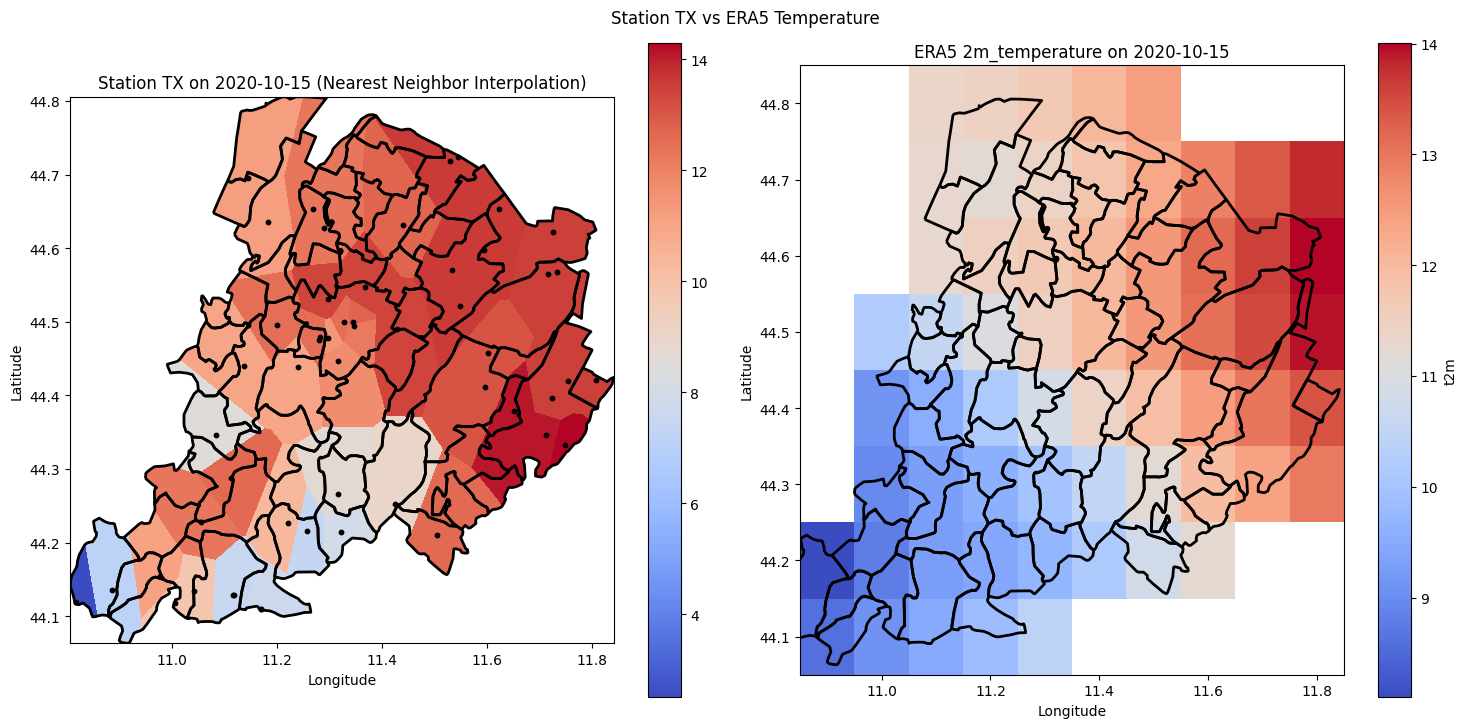

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Show the interpolated station temperature
grid_da_cropped.plot(ax=axes[0], cmap="coolwarm")
axes[0].scatter(
    bologna_station_coords[:, 1] * (x_distance / required_x_pixels) + bologna_start_lon,
    bologna_station_coords[:, 0] * (y_distance / required_y_pixels) + bologna_start_lat,
    c="black",
    s=10,
    label="Stations",
)
bologna_gadm.boundary.plot(ax=axes[0], color="black", linewidth=2)
axes[0].set_title(f"Station TX on {bologna_day} (Nearest Neighbor Interpolation)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")


# Show the interpolated ERA5 temperature
era5_bologna_tx.plot(ax=axes[1], cmap="coolwarm")
bologna_gadm.boundary.plot(ax=axes[1], color="black", linewidth=2)
axes[1].set_title(f"ERA5 {voi} on {bologna_day}")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.suptitle("Station TX vs ERA5 Temperature", y=1.02)
plt.show()